## Read this

- https://s.id/PanduanPenggunaanDGXA100
-

## Import Libraries

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
!pip uninstall transformers --y
!pip install transformers==4.35

Found existing installation: transformers 4.35.0
Uninstalling transformers-4.35.0:
  Successfully uninstalled transformers-4.35.0
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.1/123.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 63.3 MB/s eta 0:00:00


In [3]:
!pip install jupyter

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [4]:
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [5]:
!pip uninstall traitlets --y
!pip install traitlets==5.9.0

Found existing installation: traitlets 5.9.0
Uninstalling traitlets-5.9.0:
  Successfully uninstalled traitlets-5.9.0
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 3.4 MB/s eta 0:00:00


In [6]:
import os
import pandas as pd
import numpy as np
import math
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

from transformers import AutoTokenizer, AutoModel
from transformers import DataCollatorWithPadding

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence

import matplotlib.pyplot as plt
from tqdm import tqdm

# from torchsummary import summary

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## Download Model

In [7]:
tokenizer_class = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")
# model_class = AutoModel.from_pretrained("indolem/indobert-base-uncased")

# Data collator is used for padding in batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer_class)

In [8]:
class BERT_Lexidqa2_class(nn.Module):
    def __init__(self, bert, input_size = 768, output_size = 18):
        super().__init__()

        self.bert = bert

        self.dropout = nn.Dropout(0.1)

        self.relu = nn.ReLU()

        self.linear1 = nn.Linear(input_size, 512)
        self.linear2 = nn.Linear(512, output_size)

        self.id2label = {0: "T1", 1: "T2", 2: "T3", 3: "T4",
              4: "T5", 5: "T6", 6: "T7", 7: "T8", 8: "T9",
              9: "T10", 10: "T11", 11: "T12", 12: "T13",
              13: "T14", 14: "T15", 15: "T16", 16: "T17", 17: "T18"}

    def forward(self, x):
        x, _ = self.bert(x, return_dict=False)

        # Only take the first column, Pooled Output, The Context
        x = x[:, 0, :]
        x = x.view(-1, 768)

        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.linear2(x)

        return x

    def predict(input):
      output = self.forward(torch.tensor(input['input_ids']).view(1, -1))

      id_max = torch.argmax(output)
      return self.id2label[id_max.item()]

In [9]:
save_path = 'model/class/'
model_class_path = os.path.join(save_path, "indobert_class_tesaurus"+".pth")

bert_class = torch.load(model_class_path)

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [10]:
print(bert_class)

BERT_Lexidqa2_class(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31923, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

# Variables

In [11]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


# LexID QA 2 Using BERT

## Dataset Class

In [12]:
class Lexidqa2Dataset(Dataset):
  """LexID QA2 Dataset"""

  def __init__(self, dataframe, tokenizer):
    """
      dataframe (Pandas DataFrame): Dataset in DataFrame format
      tokenizer (Tokenizer) : Sentence to Vector
    """
    self.qa_frame = dataframe
    self.tokenizer = tokenizer

    self.label2id = {"T1": 1, "T2": 2, "T3": 3, "T4": 4,
                "T5": 5, "T6": 6, "T7": 7, "T8": 8, "T9": 9,
                "T10": 10, "T11": 11, "T12": 12, "T13": 13,
                "T14": 14, "T15": 15, "T16": 16, "T17": 17, "T18": 18}
    self.id2label = {1: "T1", 2: "T2", 3: "T3", 4: "T4",
                5: "T5", 6: "T6", 7: "T7", 8: "T8", 9: "T9",
                10: "T10", 11: "T11", 12: "T12", 13: "T13",
                14: "T14", 15: "T15", 16: "T16", 17: "T17", 18: "T18"}

  def __len__(self):
    return len(self.qa_frame)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    question = self.qa_frame.loc[idx, "question"]
    question_tokenized = self.tokenizer(question, truncation=True)
    question_input_ids = torch.tensor(question_tokenized['input_ids'])
    question_token_type_ids = torch.tensor(question_tokenized['token_type_ids'])
    question_attention_masks = torch.tensor(question_tokenized['attention_mask'])

    answer = self.qa_frame.loc[idx, "answer"]
    template_label = self.qa_frame.loc[idx, "template_index"]

    template_id = self.one_hot(template_label, self.label2id)

    sample = (question,
              question_input_ids,
              question_token_type_ids,
              question_attention_masks,
              answer,
              template_label,
              template_id)

    return sample

  def one_hot(self, label, label2id):
    one_hot_label = torch.zeros(len(label2id) + 1)
    one_hot_label[label2id[label]] = 1

    return one_hot_label

## Semantic Dataset

In [13]:
class Lexidqa2SemanticDataset(Dataset):
  """LexID QA2 Semantic Dataset"""

  def __init__(self, dataframe, tokenizer):
    """
      dataframe (Pandas DataFrame): Dataset in DataFrame format
      tokenizer (Tokenizer) : Sentence to Vector
    """
    self.qa_frame = dataframe
    self.tokenizer = tokenizer

    self.label2id = {"TS": 0}
    self.id2label = {0: "TS"}

  def __len__(self):
    return len(self.qa_frame)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    question = self.qa_frame.loc[idx, "Q"]
    question_tokenized = self.tokenizer(question, truncation=True)
    question_input_ids = torch.tensor(question_tokenized['input_ids'])
    question_token_type_ids = torch.tensor(question_tokenized['token_type_ids'])
    question_attention_masks = torch.tensor(question_tokenized['attention_mask'])

    answer = self.qa_frame.loc[idx, "A"]
    template_label = self.qa_frame.loc[idx, "template_index"]

    template_id = self.one_hot(template_label, self.label2id)

    sample = (question,
              question_input_ids,
              question_token_type_ids,
              question_attention_masks,
              answer,
              template_label,
              template_id)

    return sample

  def one_hot(self, label, label2id):
    one_hot_label = torch.zeros(19)
    one_hot_label[label2id[label]] = 1

    return one_hot_label

## Dataset

In [14]:
train_df = pd.read_csv("dataset/train_tesaurus.csv")
train_dataset = Lexidqa2Dataset(train_df, tokenizer_class)

In [15]:
test_df = pd.read_csv("dataset/test_tesaurus.csv")
test_dataset = Lexidqa2Dataset(test_df, tokenizer_class)

In [16]:
semantic_df = pd.read_csv("dataset/SampleQ6.csv")
semantic_df["template_index"] = "TS"
semantic_dataset = Lexidqa2SemanticDataset(semantic_df, tokenizer_class)

## Sample from dataset

In [17]:
np.random.seed(12345)
random_indices = np.random.choice(range(len(semantic_dataset)), size=5, replace=False)

for i in random_indices:
  sample = semantic_dataset[i]

  print(i, sample[0])

  if i == 5:
    break

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


69 siapa yang melakukan pengawasan penyelenggaraan pelayanan publik?
42 berapa tempat pajak terutang yang dapat ditetapkan Direktorat Jenderal Pajak?
56 apa saja bahan bakar minyak yang diberikan fasilitas pajak pertambahan nilai tidak dipungut?
35 Berapa kali pajak penjualan atas barang merah dikenakan?
16 apakah plt sekretaris jendral memiliki wewenang menandatangani naskah dinas dalam bentuk dan susunan surat dalam bidang kepegawaian?


In [18]:
# BATCH_SIZE = 32
# torch.manual_seed(12345)

# train_idx, test_idx = train_test_split(np.arange(len(semantic_dataset)), test_size=0.20, random_state=12345, shuffle=True)

# train_size = len(train_idx)
# test_size = len(test_idx)

### Save train test data to CSV

In [19]:
# train_semantic_df = semantic_df.iloc[train_idx]
# !mkdir -p dataset
# train_semantic_df.to_csv('dataset/train_semantic.csv', index=False)

In [20]:
# test_semantic_df = semantic_df.iloc[test_idx]
# !mkdir -p dataset
# test_semantic_df.to_csv('dataset/test_semantic.csv', index=False)

## Split, DataLoader

In [21]:
def collate_fn_class(data):
    """
       data: is a list of tuples with (example, label, length)
             where 'example' is a tensor of arbitrary shape
             and label/length are scalars
    """
    _, input_ids, _, _, _, _, label_ids = zip(*data)
    features = pad_sequence(input_ids, batch_first=True)
    targets = torch.stack(label_ids)
    return features, targets

### Prepare for KFold

### Load train test data

In [22]:
train_df = pd.read_csv('dataset/train_tesaurus.csv')
train_df['template_index'].value_counts()

T4     1500
T7     1500
T10    1500
T3     1500
T9     1500
T18    1500
T5     1500
T16    1500
T11    1500
T12    1500
T1     1500
T6     1500
T13    1500
T8     1500
T17    1500
T2     1500
T15     716
T14     235
Name: template_index, dtype: int64

In [23]:
test_df = pd.read_csv('dataset/test_tesaurus.csv')
test_df['template_index'].value_counts()

T17    500
T10    500
T13    500
T3     500
T2     500
T8     500
T11    500
T12    500
T4     500
T5     500
T9     500
T7     500
T18    500
T6     500
T1     500
T16    500
T15    239
T14     79
Name: template_index, dtype: int64

In [24]:
train_semantic_df = pd.read_csv('dataset/train_semantic.csv')
train_semantic_df['template_index'].value_counts()

TS    120
Name: template_index, dtype: int64

In [25]:
test_semantic_df = pd.read_csv('dataset/test_semantic.csv')
test_semantic_df['template_index'].value_counts()

TS    30
Name: template_index, dtype: int64

In [26]:
BATCH_SIZE =32
torch.manual_seed(12345)

train_df = pd.read_csv('dataset/train_tesaurus.csv')
test_df = pd.read_csv('dataset/test_tesaurus.csv')

train_semantic_df = pd.read_csv('dataset/train_semantic.csv')
test_semantic_df = pd.read_csv('dataset/test_semantic.csv')

qa_dataset_train = Lexidqa2Dataset(train_df, tokenizer_class)
qa_dataset_test = Lexidqa2Dataset(test_df, tokenizer_class)

qa_dataset_train_semantic = Lexidqa2SemanticDataset(train_semantic_df, tokenizer_class)
qa_dataset_test_semantic = Lexidqa2SemanticDataset(test_semantic_df, tokenizer_class)

# data_all_label = [qa_dataset[i][5] for i in range(len(qa_dataset))]
# train_idx, test_idx = train_test_split(np.arange(len(qa_dataset)), test_size=0.25, random_state=12345, shuffle=True, stratify=data_all_label)

train_size = len(qa_dataset_train)
test_size = len(qa_dataset_test)
train_semantic_size = len(qa_dataset_train_semantic)
test_semantic_size = len(qa_dataset_test_semantic)

data_train_label = [qa_dataset_train[i][5] for i in range(train_size)]

# test_dataset = Subset(qa_dataset, test_idx)
test_instances = DataLoader(qa_dataset_test, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_class)
test_semantic_instances = DataLoader(qa_dataset_test_semantic, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_class)

# Classification

## Model

### Loss Function

> Loss Function Multi-Class Classification: CrossEntropyLoss

In [27]:
loss_func = torch.nn.CrossEntropyLoss(reduction='mean')

### Evaluation Function

In [28]:
def confusion_matrix(gold, pred, conf_matrix):
  _, gold = torch.max(gold, 1)
  _, pred = torch.max(pred, 1)
  for g, p in zip(gold.view(-1), pred.view(-1)):
    conf_matrix[g.long(), p.long()] += 1

  return conf_matrix

In [29]:
def evaluation_metric(conf_matrix):
  nb_classes = 19
  display_labels = ['TS', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18']

  amt = amount(conf_matrix)
  # print(f"Debug Amount: {amt}")
  acc = accuracy(conf_matrix)
  prec = precision(conf_matrix)
  rec = recall(conf_matrix)
  f1 = fone(prec, rec)

  return amt, acc, prec, rec, f1

def amount(conf_matrix):
  return conf_matrix.sum(1)

def accuracy(conf_matrix):
  return conf_matrix.diag()/conf_matrix.sum(1)

def precision(conf_matrix):
  nb_classes = 19

  prec = torch.zeros(nb_classes)
  for index in range(nb_classes):
    true_positive = 0
    false_positive = 0
    for col in range(nb_classes):
      if index == col:
        true_positive = conf_matrix[col, index]
      else:
        false_positive += conf_matrix[col, index]
    prec[index] = true_positive / (true_positive + false_positive)

  return prec

def recall(conf_matrix):
  nb_classes = 19

  rec = torch.zeros(nb_classes)
  for index in range(nb_classes):
    true_positive = 0
    false_negative = 0
    for col in range(nb_classes):
      if index == col:
        true_positive = conf_matrix[index, col]
      else:
        false_negative += conf_matrix[index, col]
    rec[index] = true_positive / (true_positive + false_negative)

  return rec

def fone(prec, rec):
  nb_classes = 19

  f1 = torch.zeros(nb_classes)
  for index in range(nb_classes):
    f1[index] = 2 * (prec[index] * rec[index]) / (prec[index] + rec[index])

  return f1

### BERT + Full Connected Layer

In [30]:
class BERT_Lexidqa2_class(nn.Module):
    def __init__(self, bert, input_size = 768, output_size = 18):
        super().__init__()

        self.bert = bert

        self.dropout = nn.Dropout(0.1)

        self.relu = nn.ReLU()

        self.linear1 = nn.Linear(input_size, 512)
        self.linear2 = nn.Linear(512, output_size)

        self.id2label = {0: "T1", 1: "T2", 2: "T3", 3: "T4",
              4: "T5", 5: "T6", 6: "T7", 7: "T8", 8: "T9",
              9: "T10", 10: "T11", 11: "T12", 12: "T13",
              13: "T14", 14: "T15", 15: "T16", 16: "T17", 17: "T18"}

    def forward(self, x):
        x, _ = self.bert(x, return_dict=False)

        # Only take the first column, Pooled Output, The Context
        x = x[:, 0, :]
        x = x.view(-1, 768)

        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.linear2(x)

        return x

    def predict(input):
      output = self.forward(torch.tensor(input['input_ids']).view(1, -1))

      id_max = torch.argmax(output)
      return self.id2label[id_max.item()]

In [31]:
model = BERT_Lexidqa2_class(bert_class.bert, 768, 19)
with torch.no_grad():
  model.linear1.weight[:] = bert_class.linear1.weight.data.clone()
  model.linear2.weight[1:20] = bert_class.linear2.weight.data.clone()

## Training

> Train using 5-Fold
>
> Save checkpoint every 5 Epoch Max 20 Epoch

0it [00:00, ?it/s]

=====:=====:=====:=====:===== Fold 1 =====:=====:=====:=====:=====
Fold 1 Ready


0it [00:00, ?it/s]

Epoch 1 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.6063794294993082


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
==:==:==Train==:==:==: 0it [00:57, ?it/s]

Average Loss Validation: 0.5536898970603943
Time 0.18953680992126465

Epoch 2 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.5278350114822388


Average Loss Validation: 0.48029518127441406


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Time 0.14883995056152344

Epoch 3 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.4534943997859955


 10%|████▍                                       | 2/20 [00:00<00:03,  5.71it/s]

Average Loss Validation: 0.40790268778800964
Time 0.14909148216247559


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Epoch 4 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.3710290789604187


Average Loss Validation: 0.3362075388431549
Time 0.14585375785827637


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:00, ?it/s]


Epoch 5 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.3130977253119151


==:==:==Valid==:==:==: 0it [00:00, ?it/s]

Average Loss Validation: 0.2682526707649231
Time 0.14885973930358887


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


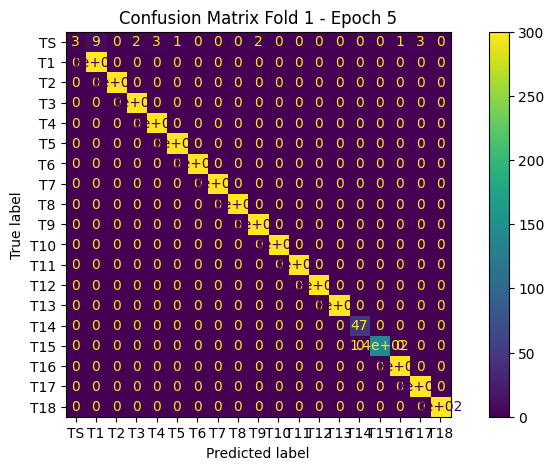

,Amount of Data,Accuracy,Precision,Recall,F One
TS,24.0,0.125,1.000000,0.125,0.222222
T1,300.0,1.000,0.970874,1.000,0.985222
T2,300.0,1.000,1.000000,1.000,1.000000
T3,300.0,1.000,0.993378,1.000,0.996678
T4,300.0,1.000,0.990099,1.000,0.995025
T5,300.0,1.000,0.996678,1.000,0.998336
T6,300.0,1.000,1.000000,1.000,1.000000
T7,300.0,1.000,1.000000,1.000,1.000000
T8,300.0,1.000,1.000000,1.000,1.000000
T9,300.0,1.000,0.993378,1.000,0.996678


0it [00:05, ?it/s]

Epoch 6 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.24259082476298013


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:05, ?it/s]

Average Loss Validation: 0.20556975901126862
Time 0.15198564529418945

Epoch 7 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.1949379543463389


Average Loss Validation: 0.15089690685272217


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:06, ?it/s]

Time 0.14949488639831543

Epoch 8 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.15426039695739746


==:==:==Valid==:==:==: 0it [00:00, ?it/s]

Average Loss Validation: 0.10922504216432571


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:06, ?it/s]

Time 0.1481494903564453

Epoch 9 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.10924984514713287


Average Loss Validation: 0.08213770389556885
Time 0.1452314853668213


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:06, ?it/s]


Epoch 10 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.08751307676235835


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.06786405295133591
Time 0.14299750328063965



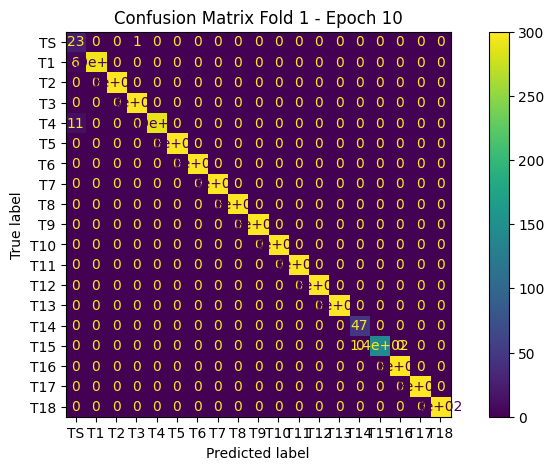

,Amount of Data,Accuracy,Precision,Recall,F One
TS,24.0,0.958333,0.575000,0.958333,0.718750
T1,300.0,0.980000,1.000000,0.980000,0.989899
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,0.996678,1.000000,0.998336
T4,300.0,0.963333,1.000000,0.963333,0.981324
T5,300.0,1.000000,1.000000,1.000000,1.000000
T6,300.0,1.000000,1.000000,1.000000,1.000000
T7,300.0,1.000000,1.000000,1.000000,1.000000
T8,300.0,1.000000,1.000000,1.000000,1.000000
T9,300.0,1.000000,1.000000,1.000000,1.000000


0it [00:11, ?it/s]

Epoch 11 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.07532290865977605


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:11, ?it/s]

Average Loss Validation: 0.0628034919500351
Time 0.14950799942016602

Epoch 12 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.07770380626122157


Average Loss Validation: 0.06274410337209702
Time 0.14649581909179688


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:11, ?it/s]


Epoch 13 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.0667807584007581


Average Loss Validation: 0.06452584266662598


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:12, ?it/s]

Time 0.14956450462341309

Epoch 14 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.07582293450832367


Average Loss Validation: 0.06621670722961426


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:12, ?it/s]

Time 0.14768767356872559

Epoch 15 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.07799395422140758


Average Loss Validation: 0.06620723754167557


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Time 0.14916539192199707



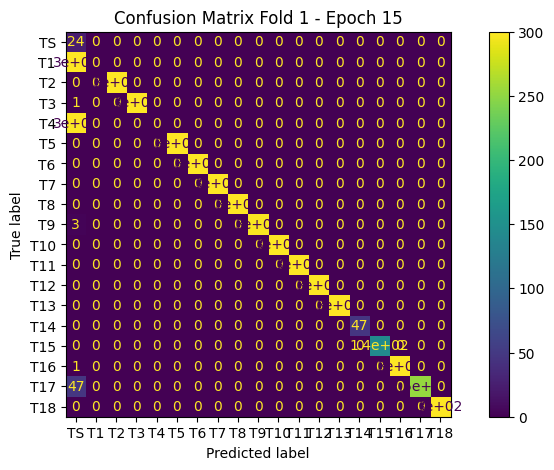

,Amount of Data,Accuracy,Precision,Recall,F One
TS,24.0,1.000000,0.035503,1.000000,0.068571
T1,300.0,0.000000,NaN,0.000000,NaN
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,0.996667,1.000000,0.996667,0.998331
T4,300.0,0.000000,NaN,0.000000,NaN
T5,300.0,1.000000,1.000000,1.000000,1.000000
T6,300.0,1.000000,1.000000,1.000000,1.000000
T7,300.0,1.000000,1.000000,1.000000,1.000000
T8,300.0,1.000000,1.000000,1.000000,1.000000
T9,300.0,0.990000,1.000000,0.990000,0.994975


0it [00:17, ?it/s]

Epoch 16 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.06011860941847166


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:17, ?it/s]

Average Loss Validation: 0.0650406926870346
Time 0.15291738510131836

Epoch 17 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.06961878140767415


Average Loss Validation: 0.0630851686000824


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:17, ?it/s]

Time 0.14929699897766113

Epoch 18 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.07518503566582997


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:17, ?it/s]

Average Loss Validation: 0.06048434227705002
Time 0.15363502502441406

Epoch 19 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.06645723059773445


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.05795346945524216
Time 0.17266488075256348



0it [00:17, ?it/s]

Epoch 20 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.05600273857514063


Average Loss Validation: 0.05588342621922493


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Time 0.18273305892944336



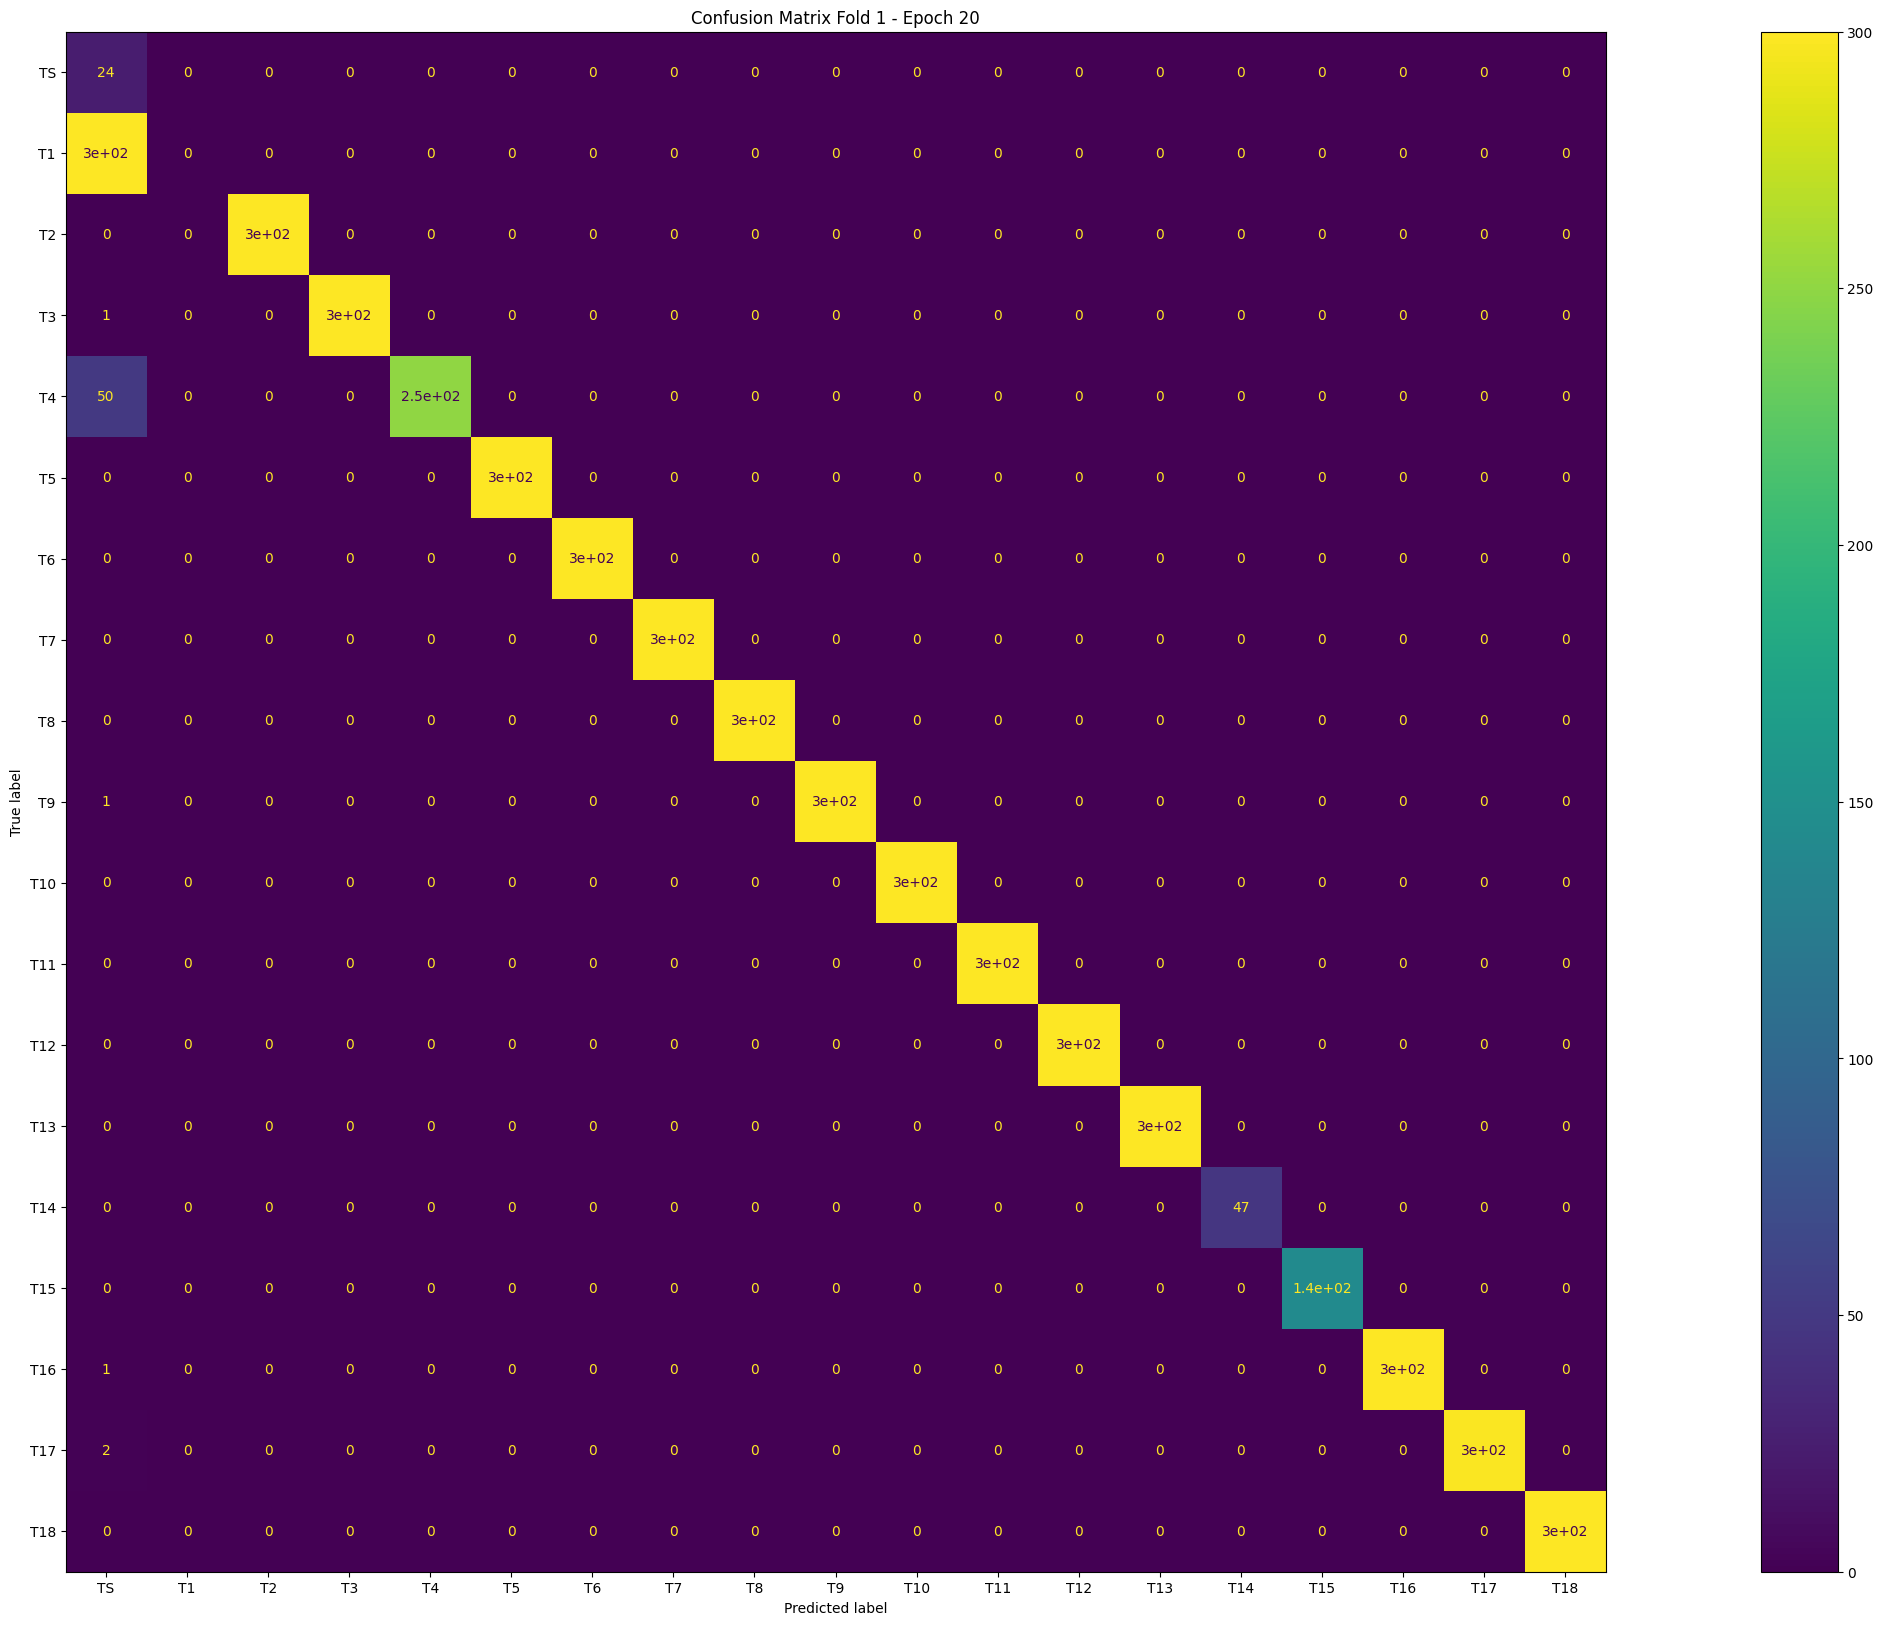

,Amount of Data,Accuracy,Precision,Recall,F One
TS,24.0,1.000000,0.063325,1.000000,0.119107
T1,300.0,0.000000,NaN,0.000000,NaN
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,0.996667,1.000000,0.996667,0.998331
T4,300.0,0.833333,1.000000,0.833333,0.909091
T5,300.0,1.000000,1.000000,1.000000,1.000000
T6,300.0,1.000000,1.000000,1.000000,1.000000
T7,300.0,1.000000,1.000000,1.000000,1.000000
T8,300.0,1.000000,1.000000,1.000000,1.000000
T9,300.0,0.996667,1.000000,0.996667,0.998331


100%|███████████████████████████████████████████| 20/20 [00:22<00:00,  1.14s/it]
0it [00:23, ?it/s]

=====:=====:=====:=====:===== Fold 1 =====:=====:=====:=====:=====


0it [00:23, ?it/s]

Fold 1 Ready


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.6553357243537903


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
  5%|██▏                                         | 1/20 [00:00<00:03,  6.25it/s]

Average Loss Validation: 0.5189077258110046
Time 0.14971661567687988

Epoch 2 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.5589081048965454


Average Loss Validation: 0.4534476399421692


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
 10%|████▍                                       | 2/20 [00:00<00:02,  6.27it/s]

Time 0.14835548400878906

Epoch 3 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.475016454855601


 10%|████▍                                       | 2/20 [00:00<00:02,  6.27it/s]

Average Loss Validation: 0.388950914144516


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
 15%|██████▌                                     | 3/20 [00:00<00:02,  6.27it/s]

Time 0.14882349967956543

Epoch 4 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.4085226853688558


Average Loss Validation: 0.3263952434062958


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
 20%|████████▊                                   | 4/20 [00:00<00:02,  6.28it/s]

Time 0.14795613288879395

Epoch 5 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.3363359272480011


 20%|████████▊                                   | 4/20 [00:00<00:02,  6.28it/s]

Average Loss Validation: 0.26674914360046387


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Time 0.14957904815673828



==:==:==Train==:==:==: 0it [01:24, ?it/s]


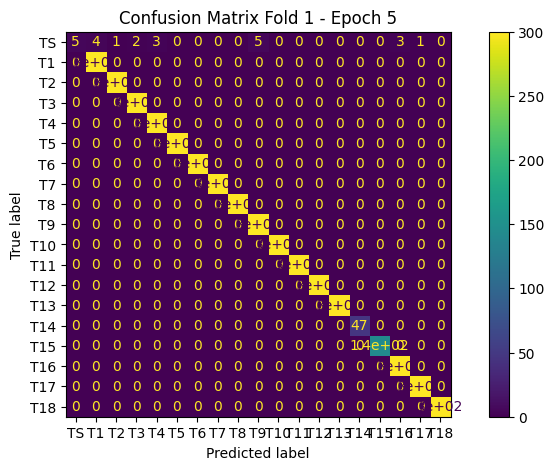

,Amount of Data,Accuracy,Precision,Recall,F One
TS,24.0,0.208333,1.000000,0.208333,0.344828
T1,300.0,1.000000,0.986842,1.000000,0.993377
T2,300.0,1.000000,0.996678,1.000000,0.998336
T3,300.0,1.000000,0.993378,1.000000,0.996678
T4,300.0,1.000000,0.990099,1.000000,0.995025
T5,300.0,1.000000,1.000000,1.000000,1.000000
T6,300.0,1.000000,1.000000,1.000000,1.000000
T7,300.0,1.000000,1.000000,1.000000,1.000000
T8,300.0,1.000000,1.000000,1.000000,1.000000
T9,300.0,1.000000,0.983607,1.000000,0.991736


 25%|███████████                                 | 5/20 [00:05<00:29,  1.96s/it]

Epoch 6 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.2718805770079295


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
 30%|█████████████▏                              | 6/20 [00:05<00:18,  1.35s/it]

Average Loss Validation: 0.21276606619358063
Time 0.14865660667419434

Epoch 7 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.21307563285032907


 30%|█████████████▏                              | 6/20 [00:06<00:18,  1.35s/it]

Average Loss Validation: 0.1668728142976761
Time 0.14818739891052246


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
 35%|███████████████▍                            | 7/20 [00:06<00:12,  1.04it/s]


Epoch 8 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.15940696994463602


0it [00:29, ?it/s]

Average Loss Validation: 0.13086354732513428
Time 0.1490039825439453


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
 40%|█████████████████▌                          | 8/20 [00:06<00:08,  1.42it/s]


Epoch 9 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.12746314952770868


 40%|█████████████████▌                          | 8/20 [00:06<00:08,  1.42it/s]

Average Loss Validation: 0.1054961234331131
Time 0.15045857429504395


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
 45%|███████████████████▊                        | 9/20 [00:06<00:05,  1.88it/s]


Epoch 10 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.10429390519857407


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.08982453495264053
Time 0.1456131935119629



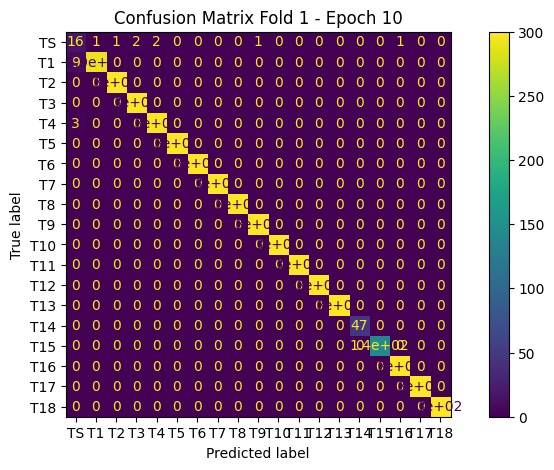

,Amount of Data,Accuracy,Precision,Recall,F One
TS,24.0,0.666667,0.571429,0.666667,0.615385
T1,300.0,0.970000,0.996575,0.970000,0.983108
T2,300.0,1.000000,0.996678,1.000000,0.998336
T3,300.0,1.000000,0.993378,1.000000,0.996678
T4,300.0,0.990000,0.993311,0.990000,0.991653
T5,300.0,1.000000,1.000000,1.000000,1.000000
T6,300.0,1.000000,1.000000,1.000000,1.000000
T7,300.0,1.000000,1.000000,1.000000,1.000000
T8,300.0,1.000000,1.000000,1.000000,1.000000
T9,300.0,1.000000,0.996678,1.000000,0.998336


 50%|█████████████████████▌                     | 10/20 [00:11<00:19,  1.93s/it]

Epoch 11 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.07970136652390163


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
 55%|███████████████████████▋                   | 11/20 [00:11<00:12,  1.38s/it]

Average Loss Validation: 0.08204355090856552
Time 0.14711523056030273

Epoch 12 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.07927537212769191


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.07894884794950485
Time 0.14461016654968262



 60%|█████████████████████████▊                 | 12/20 [00:11<00:08,  1.01s/it]

Epoch 13 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.08425099402666092


 60%|█████████████████████████▊                 | 12/20 [00:11<00:08,  1.01s/it]

Average Loss Validation: 0.077670618891716


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
 65%|███████████████████████████▉               | 13/20 [00:11<00:05,  1.33it/s]

Time 0.15362906455993652

Epoch 14 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.06816727668046951


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
 70%|██████████████████████████████             | 14/20 [00:12<00:03,  1.75it/s]

Average Loss Validation: 0.07722365856170654
Time 0.14343667030334473

Epoch 15 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.0760391503572464


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.07673442363739014
Time 0.14305853843688965



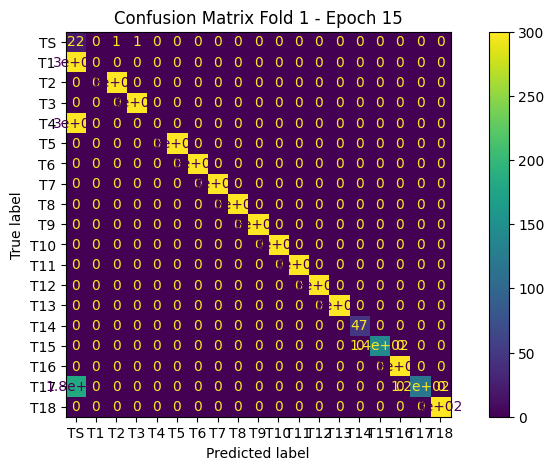

,Amount of Data,Accuracy,Precision,Recall,F One
TS,24.0,0.916667,0.027363,0.916667,0.053140
T1,300.0,0.000000,NaN,0.000000,NaN
T2,300.0,1.000000,0.996678,1.000000,0.998336
T3,300.0,1.000000,0.996678,1.000000,0.998336
T4,300.0,0.000000,NaN,0.000000,NaN
T5,300.0,1.000000,1.000000,1.000000,1.000000
T6,300.0,1.000000,1.000000,1.000000,1.000000
T7,300.0,1.000000,1.000000,1.000000,1.000000
T8,300.0,1.000000,1.000000,1.000000,1.000000
T9,300.0,1.000000,1.000000,1.000000,1.000000


 75%|████████████████████████████████▎          | 15/20 [00:16<00:09,  1.87s/it]

Epoch 16 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.06764959419767062


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
 80%|██████████████████████████████████▍        | 16/20 [00:17<00:05,  1.35s/it]

Average Loss Validation: 0.0756310373544693
Time 0.14670491218566895

Epoch 17 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.07278592884540558


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
                  

Average Loss Validation: 0.07406720519065857
Time 0.1455848217010498



 85%|████████████████████████████████████▌      | 17/20 [00:17<00:02,  1.01it/s]

Epoch 18 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.06170281767845154


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.0721004530787468
Time 0.14533162117004395



 90%|██████████████████████████████████████▋    | 18/20 [00:17<00:01,  1.35it/s]

Epoch 19 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.06714323411385219


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:40, ?it/s]

Average Loss Validation: 0.07067155092954636
Time 0.14288020133972168

Epoch 20 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.06418374801675479


 95%|████████████████████████████████████████▊  | 19/20 [00:17<00:00,  1.78it/s]

Average Loss Validation: 0.06865319609642029
Time 0.14910507202148438


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


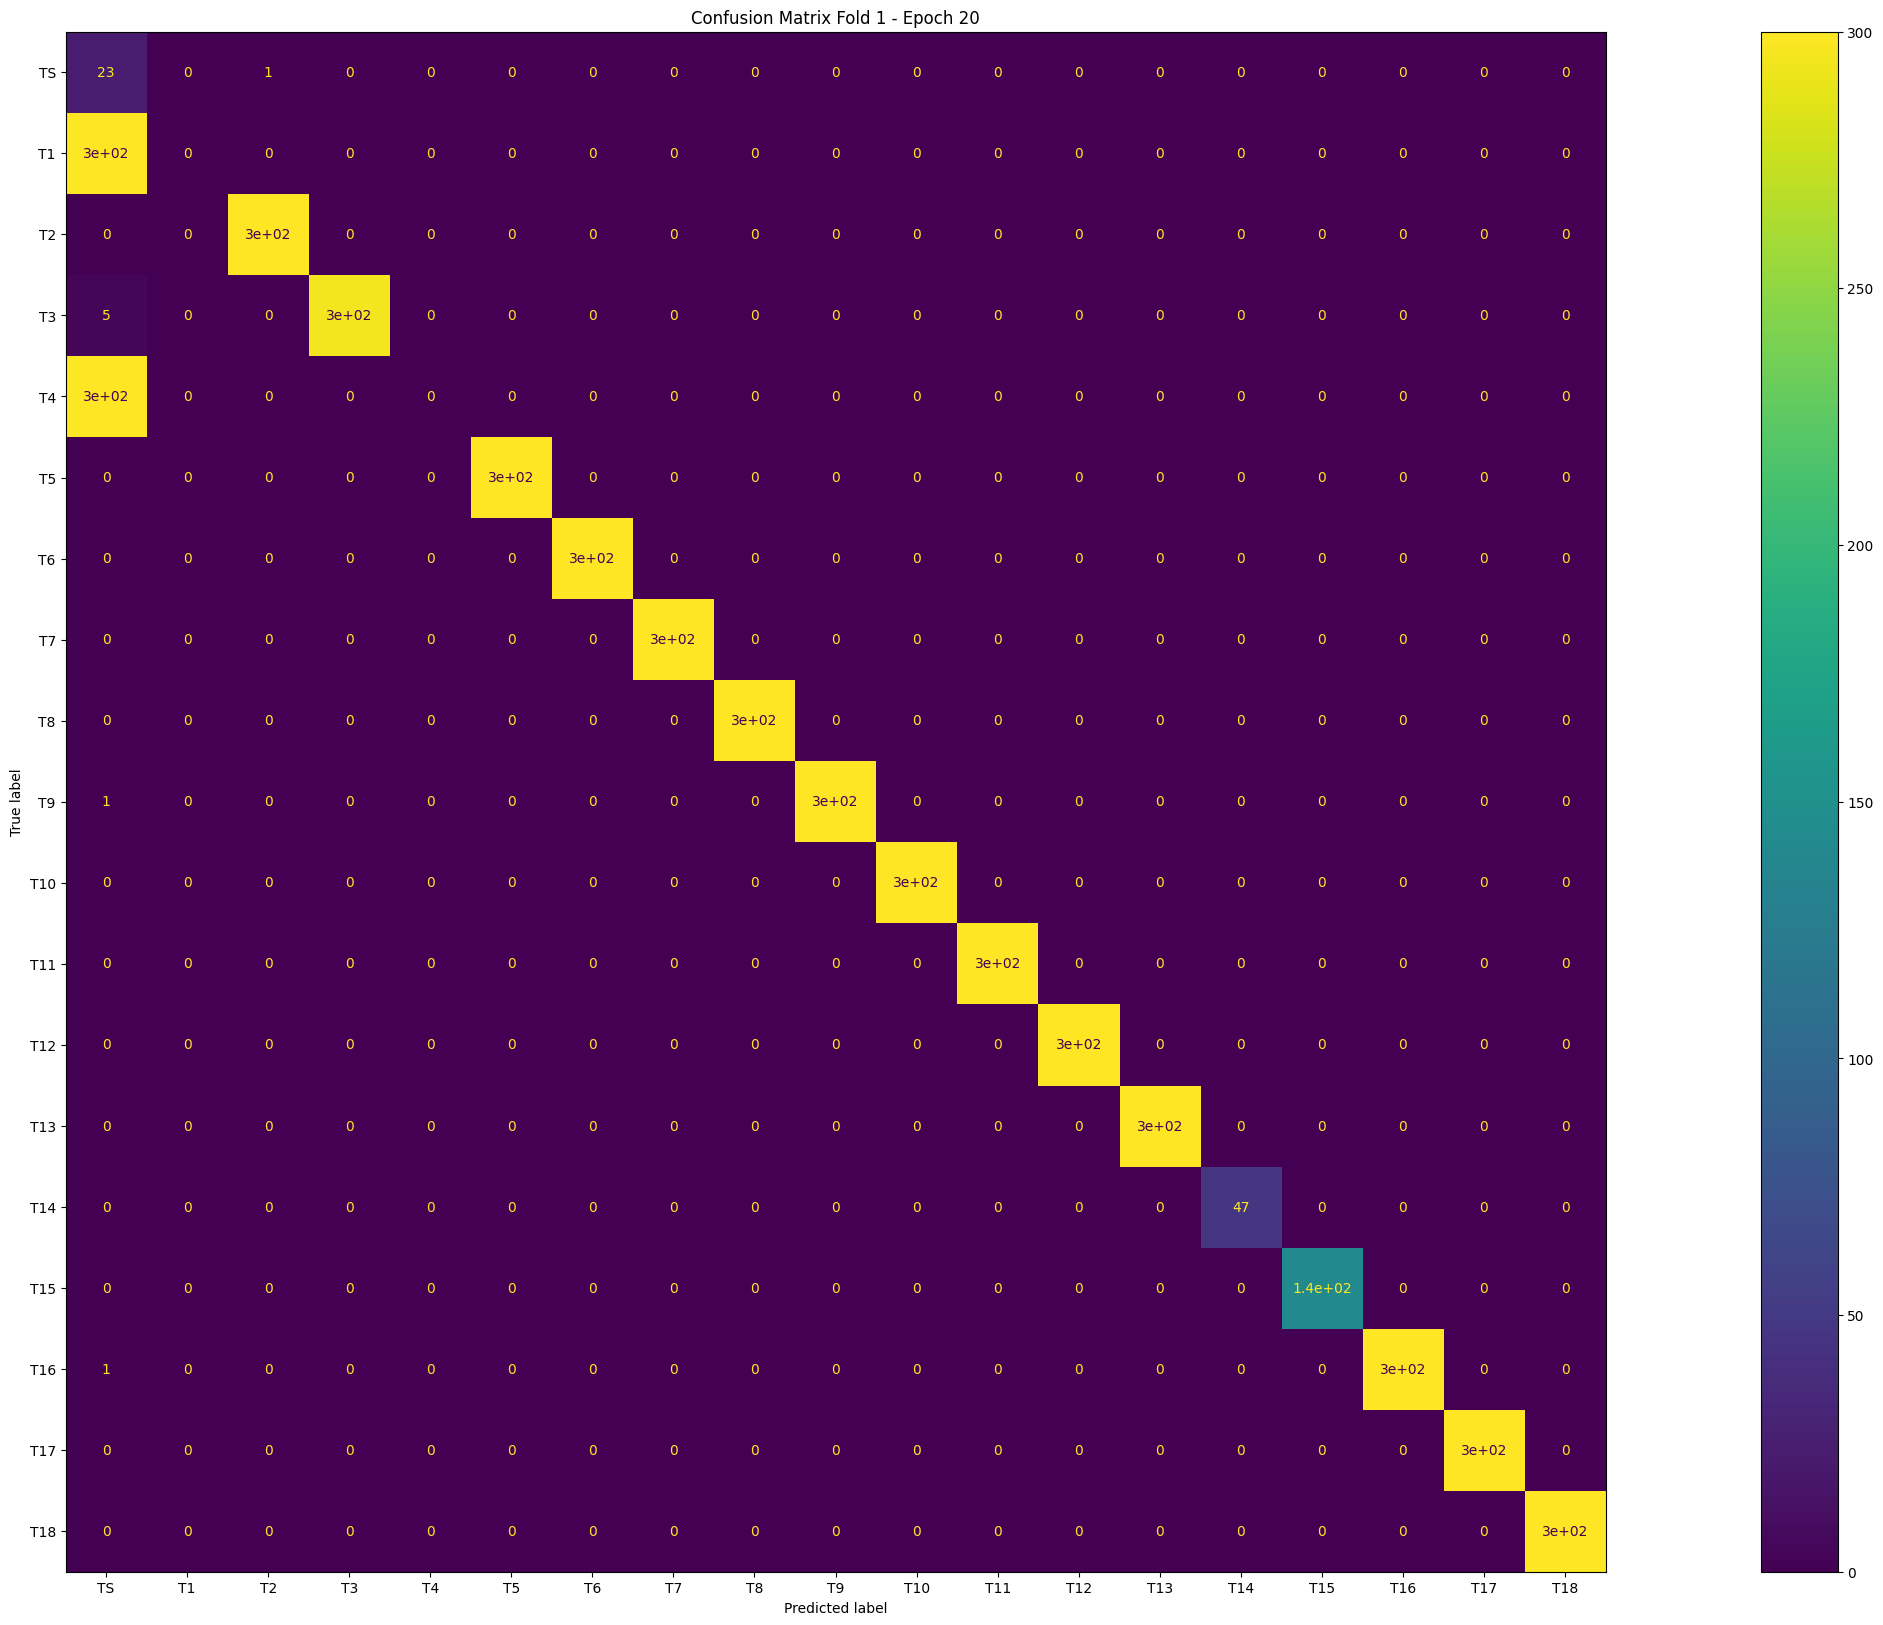

,Amount of Data,Accuracy,Precision,Recall,F One
TS,24.0,0.958333,0.036508,0.958333,0.070336
T1,300.0,0.000000,NaN,0.000000,NaN
T2,300.0,1.000000,0.996678,1.000000,0.998336
T3,300.0,0.983333,1.000000,0.983333,0.991597
T4,300.0,0.000000,NaN,0.000000,NaN
T5,300.0,1.000000,1.000000,1.000000,1.000000
T6,300.0,1.000000,1.000000,1.000000,1.000000
T7,300.0,1.000000,1.000000,1.000000,1.000000
T8,300.0,1.000000,1.000000,1.000000,1.000000
T9,300.0,0.996667,1.000000,0.996667,0.998331


100%|███████████████████████████████████████████| 20/20 [00:22<00:00,  1.14s/it]
0it [00:46, ?it/s]

=====:=====:=====:=====:===== Fold 1 =====:=====:=====:=====:=====
Fold 1 Ready


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.5884235699971517


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
  5%|██▏                                         | 1/20 [00:00<00:03,  6.27it/s]

Average Loss Validation: 0.46783092617988586
Time 0.15271425247192383

Epoch 2 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.5289515058199564


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
 10%|████▍                                       | 2/20 [00:00<00:02,  6.46it/s]

Average Loss Validation: 0.40403375029563904
Time 0.14463067054748535



 10%|████▍                                       | 2/20 [00:00<00:02,  6.46it/s]

Epoch 3 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.46912236015001935


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
 15%|██████▌                                     | 3/20 [00:00<00:02,  6.51it/s]

Average Loss Validation: 0.3405042588710785
Time 0.14533615112304688

Epoch 4 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.37645024061203003


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
 20%|████████▊                                   | 4/20 [00:00<00:02,  6.49it/s]

Average Loss Validation: 0.2787826657295227
Time 0.1474146842956543



 20%|████████▊                                   | 4/20 [00:00<00:02,  6.49it/s]

Epoch 5 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.3227129479249318


==:==:==Valid==:==:==: 0it [00:00, ?it/s]

Average Loss Validation: 0.22141164541244507
Time 0.14630556106567383



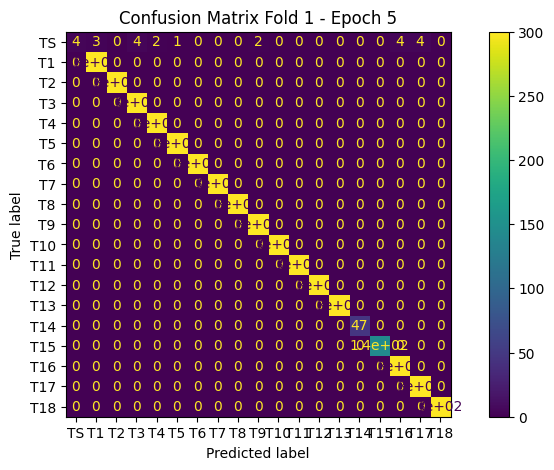

,Amount of Data,Accuracy,Precision,Recall,F One
TS,24.0,0.166667,1.000000,0.166667,0.285714
T1,300.0,1.000000,0.990099,1.000000,0.995025
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,0.986842,1.000000,0.993377
T4,300.0,1.000000,0.993378,1.000000,0.996678
T5,300.0,1.000000,0.996678,1.000000,0.998336
T6,300.0,1.000000,1.000000,1.000000,1.000000
T7,300.0,1.000000,1.000000,1.000000,1.000000
T8,300.0,1.000000,1.000000,1.000000,1.000000
T9,300.0,1.000000,0.993378,1.000000,0.996678


 25%|███████████                                 | 5/20 [00:05<00:28,  1.90s/it]

Epoch 6 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.2565836509068807


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
 30%|█████████████▏                              | 6/20 [00:05<00:18,  1.31s/it]

Average Loss Validation: 0.1711679846048355
Time 0.15197491645812988

Epoch 7 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.1943906992673874


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
 35%|███████████████▍                            | 7/20 [00:05<00:12,  1.07it/s]

Average Loss Validation: 0.1308126449584961
Time 0.15734148025512695

Epoch 8 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.14992591738700867


Average Loss Validation: 0.10211421549320221
Time 0.14864468574523926


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
 40%|█████████████████▌                          | 8/20 [00:06<00:08,  1.45it/s]


Epoch 9 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.1206769049167633


Average Loss Validation: 0.08433946222066879


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
 45%|███████████████████▊                        | 9/20 [00:06<00:05,  1.91it/s]

Time 0.1517488956451416

Epoch 10 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.09370474765698115


Average Loss Validation: 0.07582017779350281
Time 0.14718246459960938


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


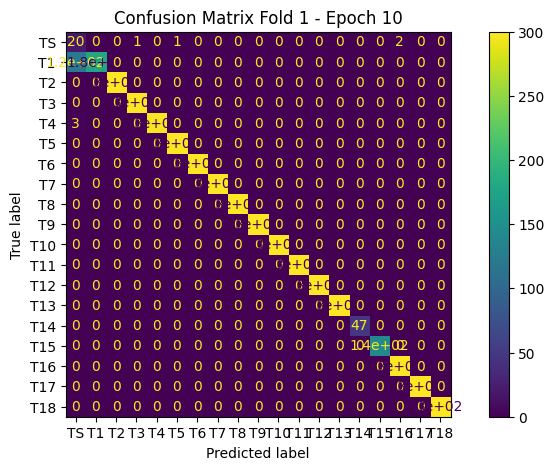

,Amount of Data,Accuracy,Precision,Recall,F One
TS,24.0,0.833333,0.136986,0.833333,0.235294
T1,300.0,0.590000,1.000000,0.590000,0.742138
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,0.996678,1.000000,0.998336
T4,300.0,0.990000,1.000000,0.990000,0.994975
T5,300.0,1.000000,0.996678,1.000000,0.998336
T6,300.0,1.000000,1.000000,1.000000,1.000000
T7,300.0,1.000000,1.000000,1.000000,1.000000
T8,300.0,1.000000,1.000000,1.000000,1.000000
T9,300.0,1.000000,1.000000,1.000000,1.000000


 50%|█████████████████████▌                     | 10/20 [00:11<00:20,  2.02s/it]

Epoch 11 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.07340844223896663


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
 55%|███████████████████████▋                   | 11/20 [00:11<00:13,  1.45s/it]

Average Loss Validation: 0.07288917899131775
Time 0.15106511116027832

Epoch 12 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.07901876668135326


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
 60%|█████████████████████████▊                 | 12/20 [00:11<00:08,  1.06s/it]

Average Loss Validation: 0.07345394790172577
Time 0.15817761421203613

Epoch 13 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.07528361057241757


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.07450899481773376
Time 0.14599299430847168



 65%|███████████████████████████▉               | 13/20 [00:12<00:05,  1.27it/s]

Epoch 14 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.0651867613196373


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
                  

Average Loss Validation: 0.07591668516397476
Time 0.14624857902526855



 70%|██████████████████████████████             | 14/20 [00:12<00:03,  1.68it/s]

Epoch 15 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.06097746888796488


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.07688216120004654
Time 0.14497876167297363



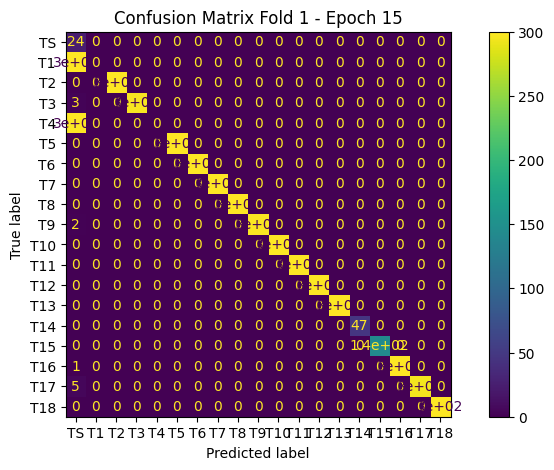

,Amount of Data,Accuracy,Precision,Recall,F One
TS,24.0,1.000000,0.037795,1.000000,0.072838
T1,300.0,0.000000,NaN,0.000000,NaN
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,0.990000,1.000000,0.990000,0.994975
T4,300.0,0.000000,NaN,0.000000,NaN
T5,300.0,1.000000,1.000000,1.000000,1.000000
T6,300.0,1.000000,1.000000,1.000000,1.000000
T7,300.0,1.000000,1.000000,1.000000,1.000000
T8,300.0,1.000000,1.000000,1.000000,1.000000
T9,300.0,0.993333,1.000000,0.993333,0.996656


 75%|████████████████████████████████▎          | 15/20 [00:17<00:09,  1.93s/it]

Epoch 16 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.06008985141913096


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
 80%|██████████████████████████████████▍        | 16/20 [00:17<00:05,  1.40s/it]

Average Loss Validation: 0.0765439048409462
Time 0.147566556930542

Epoch 17 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.06270622089505196


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
                                                                                

Average Loss Validation: 0.07560763508081436
Time 0.14607858657836914



 85%|████████████████████████████████████▌      | 17/20 [00:17<00:03,  1.02s/it]

Epoch 18 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.07098935047785442


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
 90%|██████████████████████████████████████▋    | 18/20 [00:17<00:01,  1.31it/s]

Average Loss Validation: 0.07371155172586441
Time 0.1466972827911377



 90%|██████████████████████████████████████▋    | 18/20 [00:17<00:01,  1.31it/s]

Epoch 19 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.07146528363227844


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.07079720497131348
Time 0.14585351943969727



 95%|████████████████████████████████████████▊  | 19/20 [00:17<00:00,  1.73it/s]

Epoch 20 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.049276510874430336


==:==:==Valid==:==:==: 0it [00:00, ?it/s]

Average Loss Validation: 0.0679204985499382
Time 0.15125370025634766


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


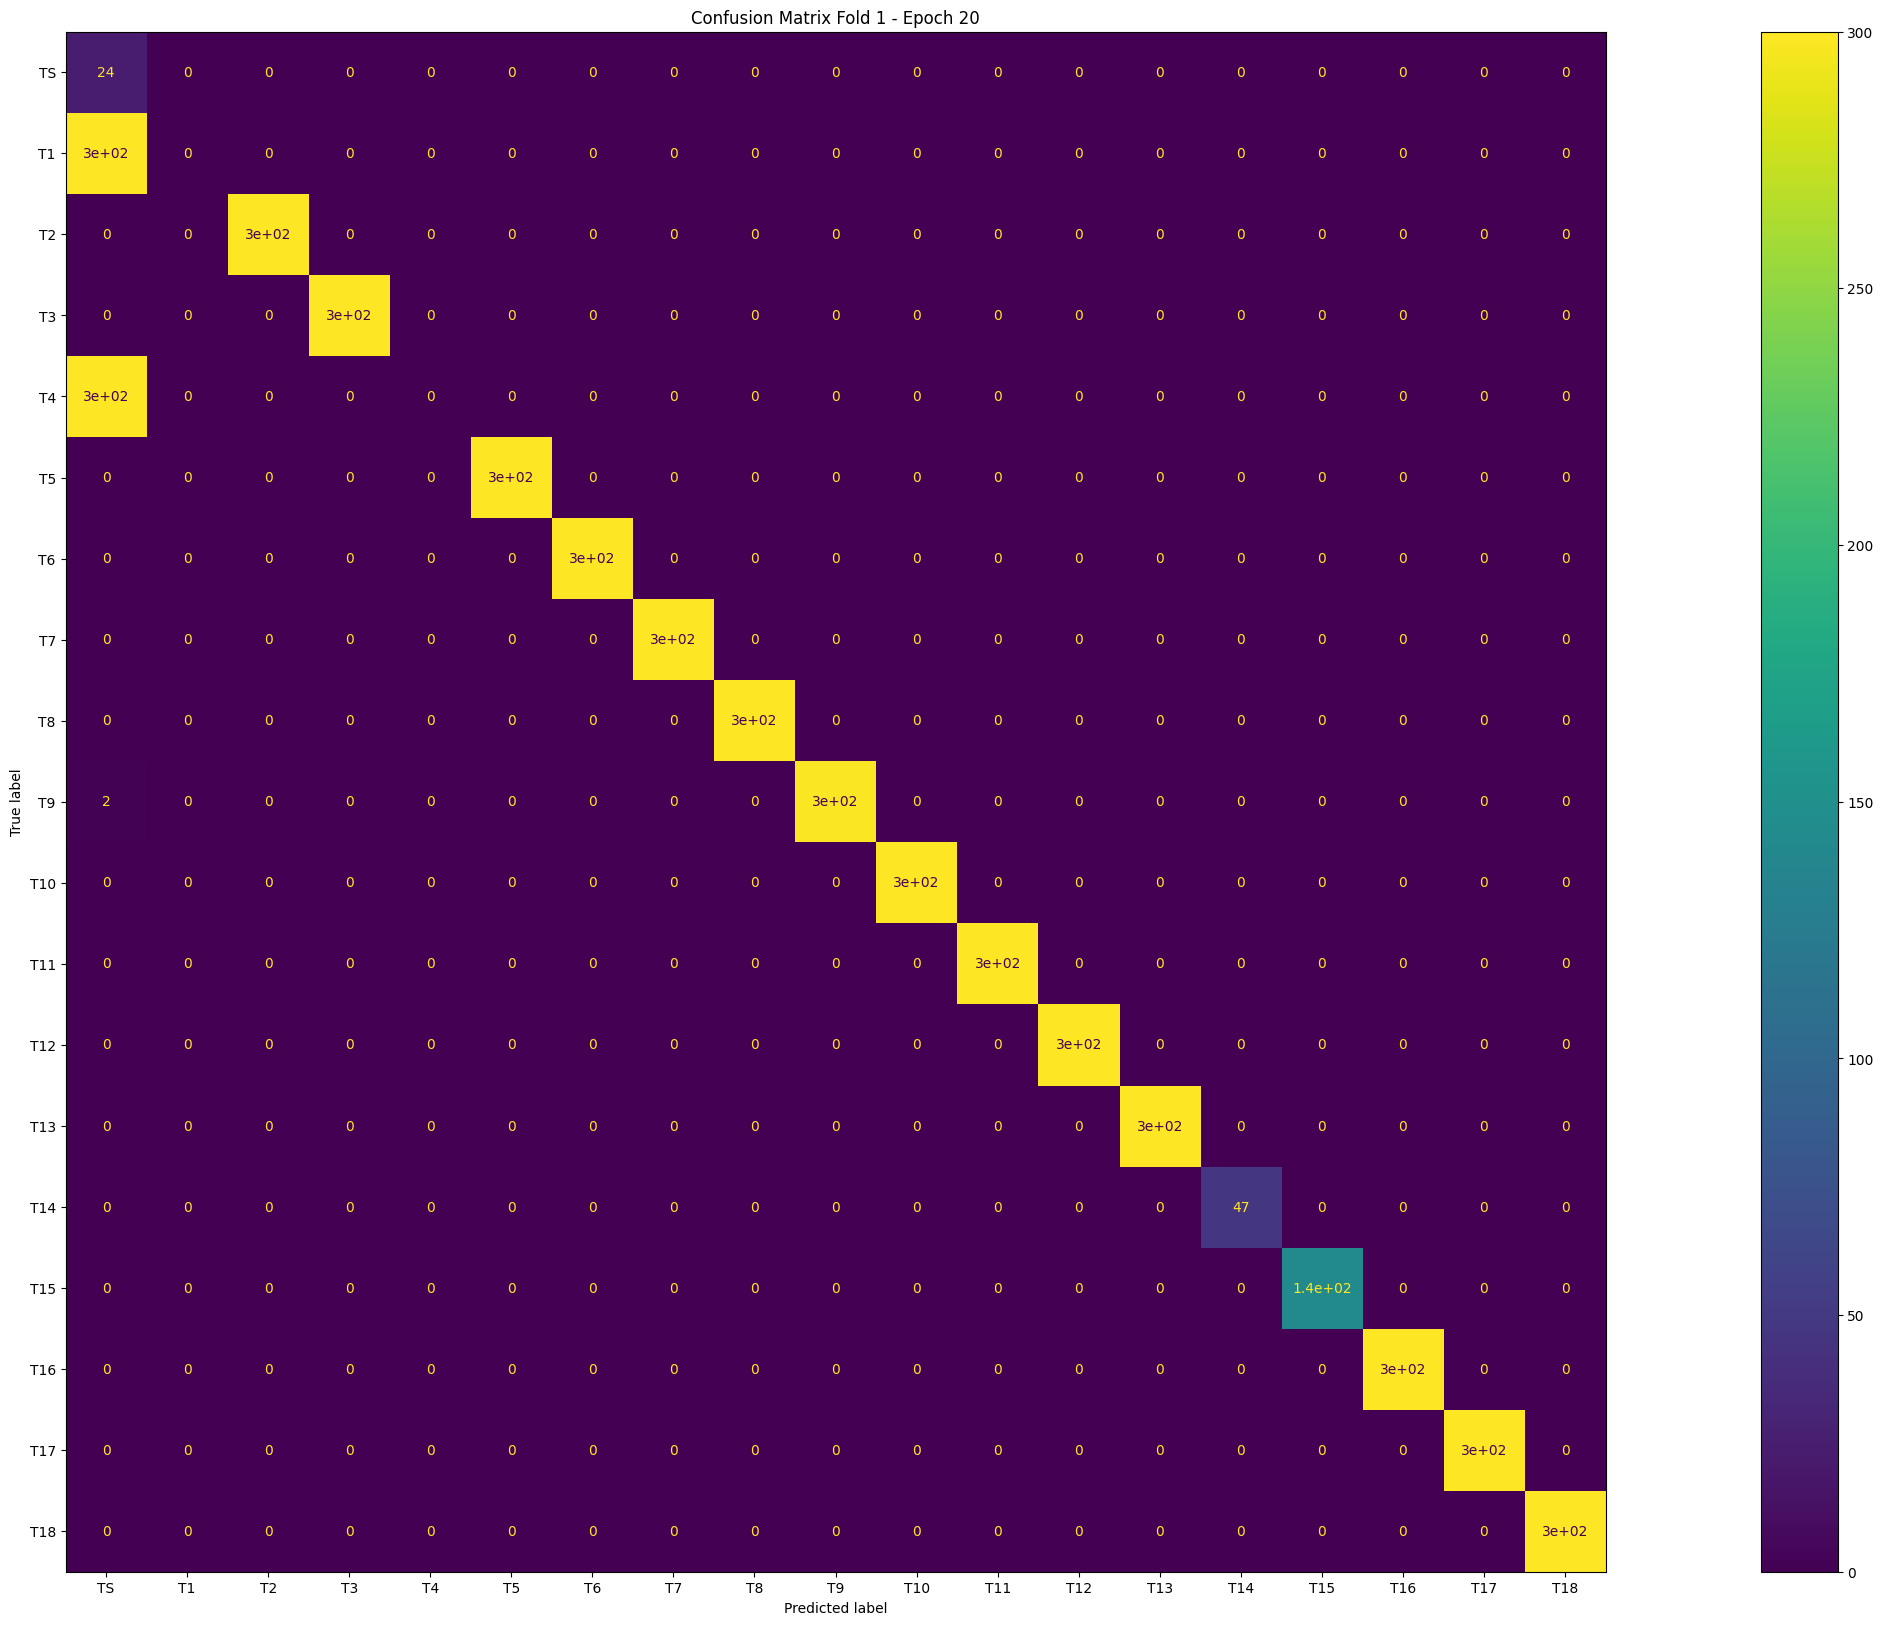

,Amount of Data,Accuracy,Precision,Recall,F One
TS,24.0,1.000000,0.038339,1.000000,0.073846
T1,300.0,0.000000,NaN,0.000000,NaN
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,1.000000,1.000000,1.000000
T4,300.0,0.000000,NaN,0.000000,NaN
T5,300.0,1.000000,1.000000,1.000000,1.000000
T6,300.0,1.000000,1.000000,1.000000,1.000000
T7,300.0,1.000000,1.000000,1.000000,1.000000
T8,300.0,1.000000,1.000000,1.000000,1.000000
T9,300.0,0.993333,1.000000,0.993333,0.996656


100%|███████████████████████████████████████████| 20/20 [00:23<00:00,  1.17s/it]
0it [01:09, ?it/s]

=====:=====:=====:=====:===== Fold 1 =====:=====:=====:=====:=====
Fold 1 Ready


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.565340538819631


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
  5%|██▏                                         | 1/20 [00:00<00:02,  6.35it/s]

Average Loss Validation: 0.5378245711326599
Time 0.14981818199157715

Epoch 2 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.4925683041413625


  5%|██▏                                         | 1/20 [00:00<00:02,  6.35it/s]

Average Loss Validation: 0.4712129831314087
Time 0.14513731002807617



==:==:==Valid==:==:==: 0it [00:00, ?it/s]
 10%|████▍                                       | 2/20 [00:00<00:02,  6.45it/s]

Epoch 3 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.4336392879486084


Average Loss Validation: 0.40585267543792725
Time 0.1465892791748047



==:==:==Valid==:==:==: 0it [00:00, ?it/s]
 15%|██████▌                                     | 3/20 [00:00<00:02,  6.46it/s]

Epoch 4 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.36573920647303265


Average Loss Validation: 0.34096649289131165
Time 0.14739322662353516


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
 20%|████████▊                                   | 4/20 [00:00<00:02,  6.44it/s]


Epoch 5 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.3041087289651235


Average Loss Validation: 0.27883180975914


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Time 0.14876532554626465



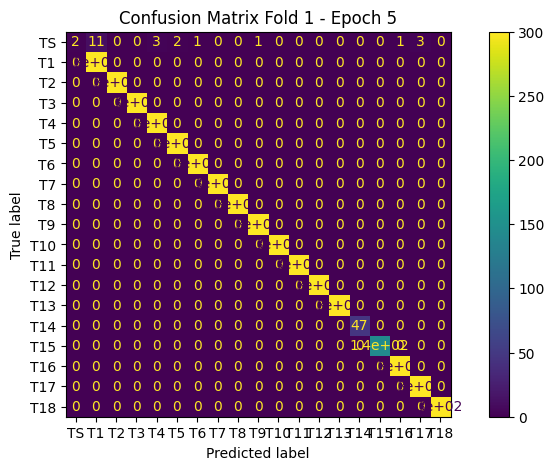

,Amount of Data,Accuracy,Precision,Recall,F One
TS,24.0,0.083333,1.000000,0.083333,0.153846
T1,300.0,1.000000,0.964630,1.000000,0.981997
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,1.000000,1.000000,1.000000
T4,300.0,1.000000,0.990099,1.000000,0.995025
T5,300.0,1.000000,0.993378,1.000000,0.996678
T6,300.0,1.000000,0.996678,1.000000,0.998336
T7,300.0,1.000000,1.000000,1.000000,1.000000
T8,300.0,1.000000,1.000000,1.000000,1.000000
T9,300.0,1.000000,0.996678,1.000000,0.998336


 25%|███████████                                 | 5/20 [00:05<00:28,  1.89s/it]

Epoch 6 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.2606714169184367


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
 30%|█████████████▏                              | 6/20 [00:05<00:18,  1.30s/it]

Average Loss Validation: 0.22120358049869537
Time 0.15257883071899414

Epoch 7 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.18976567685604095


==:==:==Valid==:==:==: 0it [00:00, ?it/s]

Average Loss Validation: 0.17071765661239624
Time 0.14450645446777344




 35%|███████████████▍                            | 7/20 [00:05<00:12,  1.08it/s]

Epoch 8 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.1544396032889684


==:==:==Valid==:==:==: 0it [00:00, ?it/s]

Average Loss Validation: 0.13046476244926453
Time 0.1504204273223877


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
 40%|█████████████████▌                          | 8/20 [00:06<00:08,  1.47it/s]


Epoch 9 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.13105124235153198


Average Loss Validation: 0.10167110711336136


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
 45%|███████████████████▊                        | 9/20 [00:06<00:05,  1.93it/s]

Time 0.1493394374847412

Epoch 10 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.10041304677724838


0it [01:16, ?it/s]

Average Loss Validation: 0.08363303542137146
Time 0.1479337215423584


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


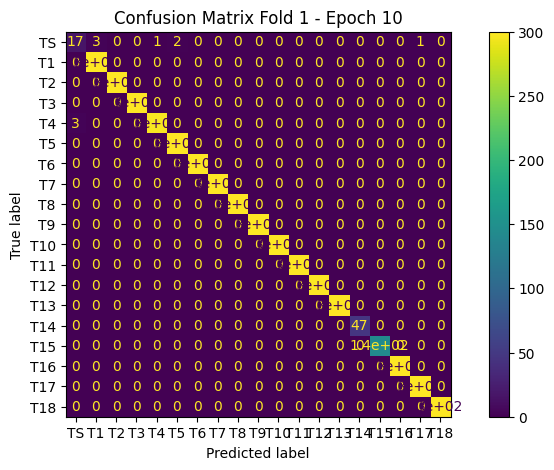

,Amount of Data,Accuracy,Precision,Recall,F One
TS,24.0,0.708333,0.850000,0.708333,0.772727
T1,300.0,1.000000,0.990099,1.000000,0.995025
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,1.000000,1.000000,1.000000
T4,300.0,0.990000,0.996644,0.990000,0.993311
T5,300.0,1.000000,0.993378,1.000000,0.996678
T6,300.0,1.000000,1.000000,1.000000,1.000000
T7,300.0,1.000000,1.000000,1.000000,1.000000
T8,300.0,1.000000,1.000000,1.000000,1.000000
T9,300.0,1.000000,1.000000,1.000000,1.000000


 50%|█████████████████████▌                     | 10/20 [00:11<00:19,  1.92s/it]

Epoch 11 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.08275128652652104


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
 55%|███████████████████████▋                   | 11/20 [00:11<00:12,  1.38s/it]

Average Loss Validation: 0.07446614652872086
Time 0.15102863311767578

Epoch 12 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]


Average Loss Train: 0.08133742709954579


 55%|███████████████████████▋                   | 11/20 [00:11<00:09,  1.05s/it]
0it [01:21, ?it/s]


KeyboardInterrupt: 

In [37]:
import time
torch.manual_seed(12345)

# training image classification

LEARNING_RATE = 5e-5
EPOCH = 20

model.to(DEVICE)

training_losses = [[] for i in range(5)]
validation_losses = [[] for i in range(5)]

skf = StratifiedKFold(n_splits=5)
kf = KFold(n_splits=5)

# Load before training + validing
for fold_i, (train_index, val_index) in enumerate(tqdm(skf.split(np.zeros(len(qa_dataset_train)), data_train_label), position=0, leave=True)):
  for _, (train_semantic_index, val_semantic_index) in enumerate(kf.split(np.zeros(len(qa_dataset_train_semantic)))):
    tqdm.write(f"=====:=====:=====:=====:===== Fold {fold_i + 1} =====:=====:=====:=====:=====")

    # Subset dataset for train and val
    train_dataset = Subset(qa_dataset_train, train_index)
    valid_dataset = Subset(qa_dataset_train, val_index)

    train_semantic_dataset = Subset(qa_dataset_train_semantic, train_semantic_index)
    valid_semantic_dataset = Subset(qa_dataset_train_semantic, val_semantic_index)

    train_size = len(train_dataset)
    valid_size = len(valid_dataset)
    train_semantic_size = len(train_semantic_dataset)
    valid_semantic_size = len(valid_semantic_dataset)

    train_instances = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_class)
    valid_instances = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_class)

    train_semantic_instances = DataLoader(train_semantic_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_class)
    valid_semantic_instances = DataLoader(valid_semantic_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_class)

    save_path = 'model/class/'
    model_class_path = os.path.join(save_path, "indobert_class_tesaurus"+".pth")

    bert_class = torch.load(model_class_path)
    model = BERT_Lexidqa2_class(bert_class.bert, 768, 19)
    with torch.no_grad():
      model.linear1.weight[:] = bert_class.linear1.weight.data.clone()
      model.linear2.weight[1:20] = bert_class.linear2.weight.data.clone()
    model.to(DEVICE)

    # optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE)

    tqdm.write(f'Fold {fold_i + 1} Ready')

    for epoch_i in tqdm(range(0, EPOCH), position=0, leave=True):
      start = time.time()
      tqdm.write(f"Epoch {epoch_i + 1} / {EPOCH}")

      # Freeze all layers and fcl
      for param in model.parameters():
          param.requires_grad = False
      for param in model.linear1.parameters():
          param.requires_grad = True
      for param in model.linear2.parameters():
        param.requires_grad = True

      # Reset the total loss for this epoch.
      tr_loss = 0

      # Put the model into training mode.
      model.train()

      # Untuk setiap data di training data
      train_total_data = 0
      train_pbar = tqdm(desc="==:==:==Train==:==:==", position=0, leave=True)
      for data, data_semantic in zip(train_instances, train_semantic_instances):

        # Mendapatkan output dari model
        train_total_data += len(data) + len(data_semantic)


        input_1, gold_1 = data
        input_2, gold_2 = data_semantic

        input = pad_sequence([*input_1, *input_2], batch_first=True)
        gold =pad_sequence([*gold_1, *gold_2], batch_first=True)

        input = input.to(DEVICE)
        gold = gold.to(DEVICE)
        pred = model(input)

        # Categorical Cross-Entropy --- Loss Function
        loss = loss_func(pred, gold)

        # Agar gradient tidak menumpuk; ini diperlukan sebelum
        # menghitung gradient dengan loss.backward()
        optimizer.zero_grad()

        # hitung gradient
        loss.backward()

        # update parameter
        optimizer.step()

        # akumulasi loss dalam 1 epoch
        tr_loss += loss.item()

        # train_pbar.update(len(data))

      # rata-rata loss dalam 1 epoch
      avg_loss = tr_loss / train_total_data

      training_losses[fold_i].append(avg_loss)

      train_pbar.write(f"Average Loss Train: {avg_loss}")

      train_pbar.close()

      ### Uji coba di Validation Data

      # model eval, agar layer seperti dropout yang menghasilkan
      # sesuai yang random tidak digunakan
      model.eval()

      val_loss = 0
      pred_labels = []
      true_labels = []

      # Untuk setiap batch di validation data
      valid_total_data = 0
      valid_pbar = tqdm(desc="==:==:==Valid==:==:==", position=0, leave=True)
      for data, data_semantic in zip(valid_instances, valid_semantic_instances):

        # jangan track gradient! ini sedang evaluasi, bukan training
        with torch.no_grad():

          valid_total_data += len(data) + len(data_semantic)

          # Mendapatkan output dari model
          input_1, gold_1 = data
          input_2, gold_2 = data_semantic
          input = pad_sequence([*input_1, *input_2], batch_first=True)
          gold =pad_sequence([*gold_1, *gold_2], batch_first=True)

          input = input.to(DEVICE)
          gold = gold.to(DEVICE)
          pred = model(input)

          # Categorical Cross-Entropy --- Loss Function
          loss = loss_func(pred, gold)

          # akumulasi loss di validation set
          val_loss += loss.item()

          # valid_pbar.update(len(data))


      # average loss
      avg_val_loss = val_loss / valid_total_data

      validation_losses[fold_i].append(avg_val_loss)

      valid_pbar.write(f"Average Loss Validation: {avg_val_loss}")

      end = time.time()
      valid_pbar.write("Time " + str(end-start))
      valid_pbar.write("")
      valid_pbar.close()

      # accuracy
      # pred_labels = torch.stack(pred_labels).numpy()
      # true_labels = torch.stack(true_labels).numpy()
      # val_accuracy = np.sum(pred_labels == true_labels) / len(pred_labels)
      # print(f"Accuracy di validation data: {val_accuracy}")


      if (epoch_i + 1) % 5 == 0:
        nb_classes = 19

        conf_matrix = torch.zeros(nb_classes, nb_classes)
        with torch.no_grad():
          for i, (input, gold) in enumerate(valid_instances):
            input = input.to(DEVICE)
            gold = gold.to(DEVICE)
            pred = model(input)
            # _, gold = torch.max(gold, 1)
            # _, pred = torch.max(pred, 1)
            # for t, p in zip(gold.view(-1), pred.view(-1)):
            #   conf_matrix[t.long(), p.long()] += 1

            conf_matrix = confusion_matrix(gold, pred, conf_matrix)

          for i, (input, gold) in enumerate(valid_semantic_instances):
            input = input.to(DEVICE)
            gold = gold.to(DEVICE)
            pred = model(input)
            # _, gold = torch.max(gold, 1)
            # _, pred = torch.max(pred, 1)
            # for t, p in zip(gold.view(-1), pred.view(-1)):
            #   conf_matrix[t.long(), p.long()] += 1

            conf_matrix = confusion_matrix(gold, pred, conf_matrix)

        amt, acc, prec, rec, f1 = evaluation_metric(conf_matrix)
        data_conf = {
            'Amount of Data': amt,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F One': f1
        }


        fig, ax = _, _
        if (epoch_i + 1) != EPOCH:
          fig, ax = plt.subplots(figsize=(10, 5))
        else:
          fig, ax = plt.subplots(figsize=(40, 20))

        display_labels = ['TS', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18']
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix.detach().cpu().numpy(), display_labels=display_labels)
        disp.plot(ax=ax)
        plt.title(f"Confusion Matrix Fold {fold_i + 1} - Epoch {epoch_i + 1}")
        plt.show()

        disp_df = pd.DataFrame(data=data_conf,
                              index=display_labels, columns=['Amount of Data', 'Accuracy', 'Precision', 'Recall', 'F One'])
        display(disp_df)

        # for i, template_index in enumerate(display_labels):
        #   print(f"Evaluation for {template_index}:")
        #   print(f"Amount of Data: {amt[i]}")
        #   print(f"Accuracy: {acc[i]}")
        #   print(f"Precision: {prec[i]}")
        #   print(f"Recall: {rec[i]}")
        #   print(f"F One: {f1[i]}")
        #   print()

        model.to("cpu")

        save_path = 'model_semantic/class_checkpoint/fold_' + str(fold_i)
        if not os.path.exists(save_path):
          os.makedirs(save_path)
        model_class_path = os.path.join(save_path, "indobert_class_semantic_checkpoint_" + str(epoch_i) +".pth")
        torch.save(model, model_class_path)

        model.to(DEVICE)

### Visualize

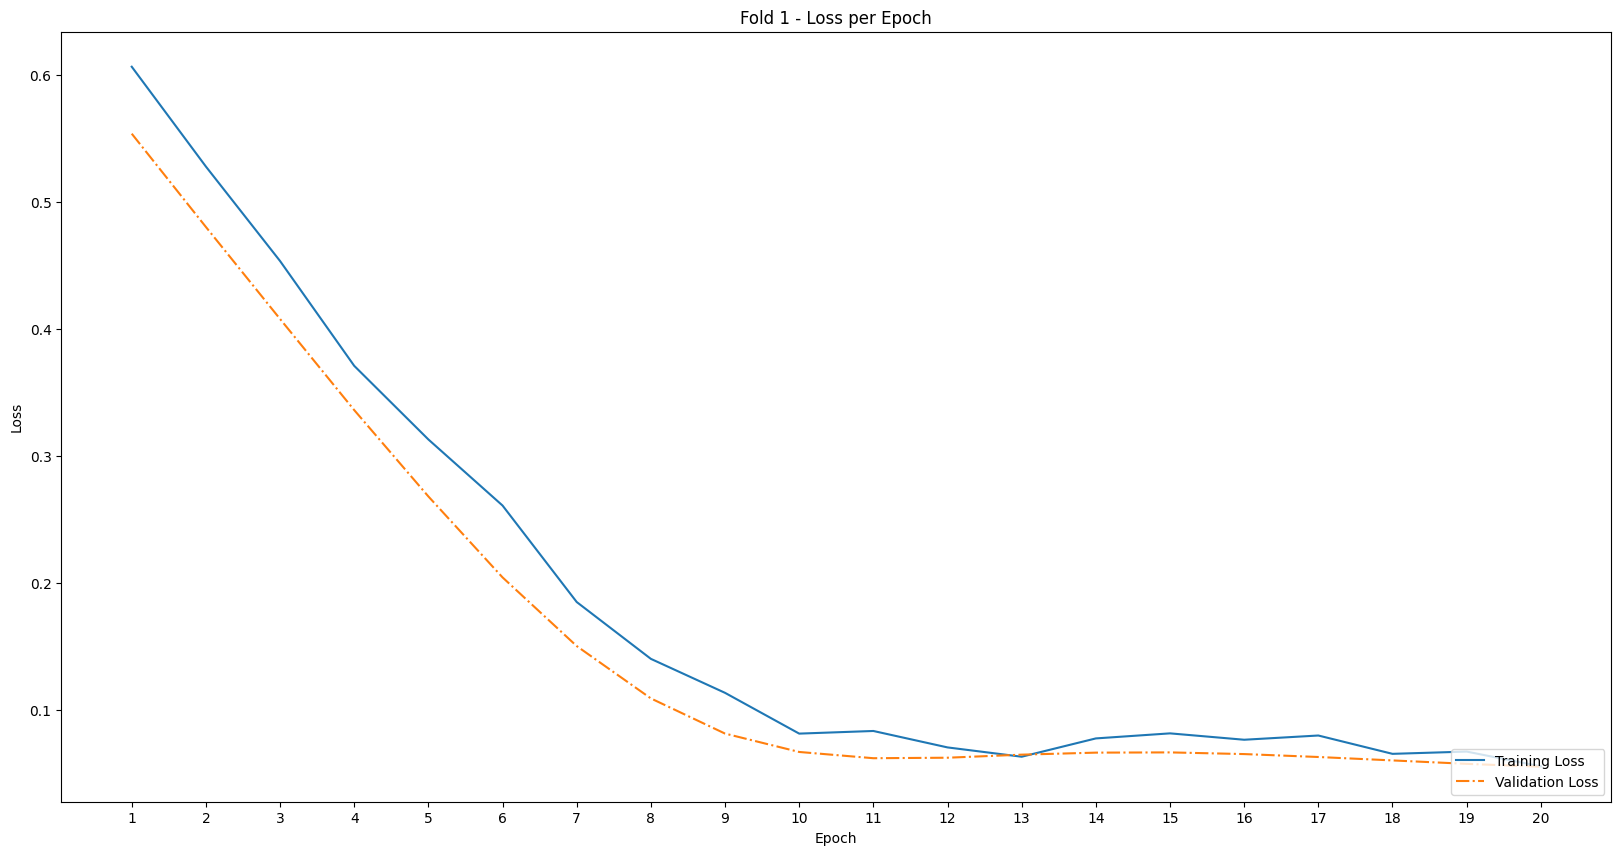

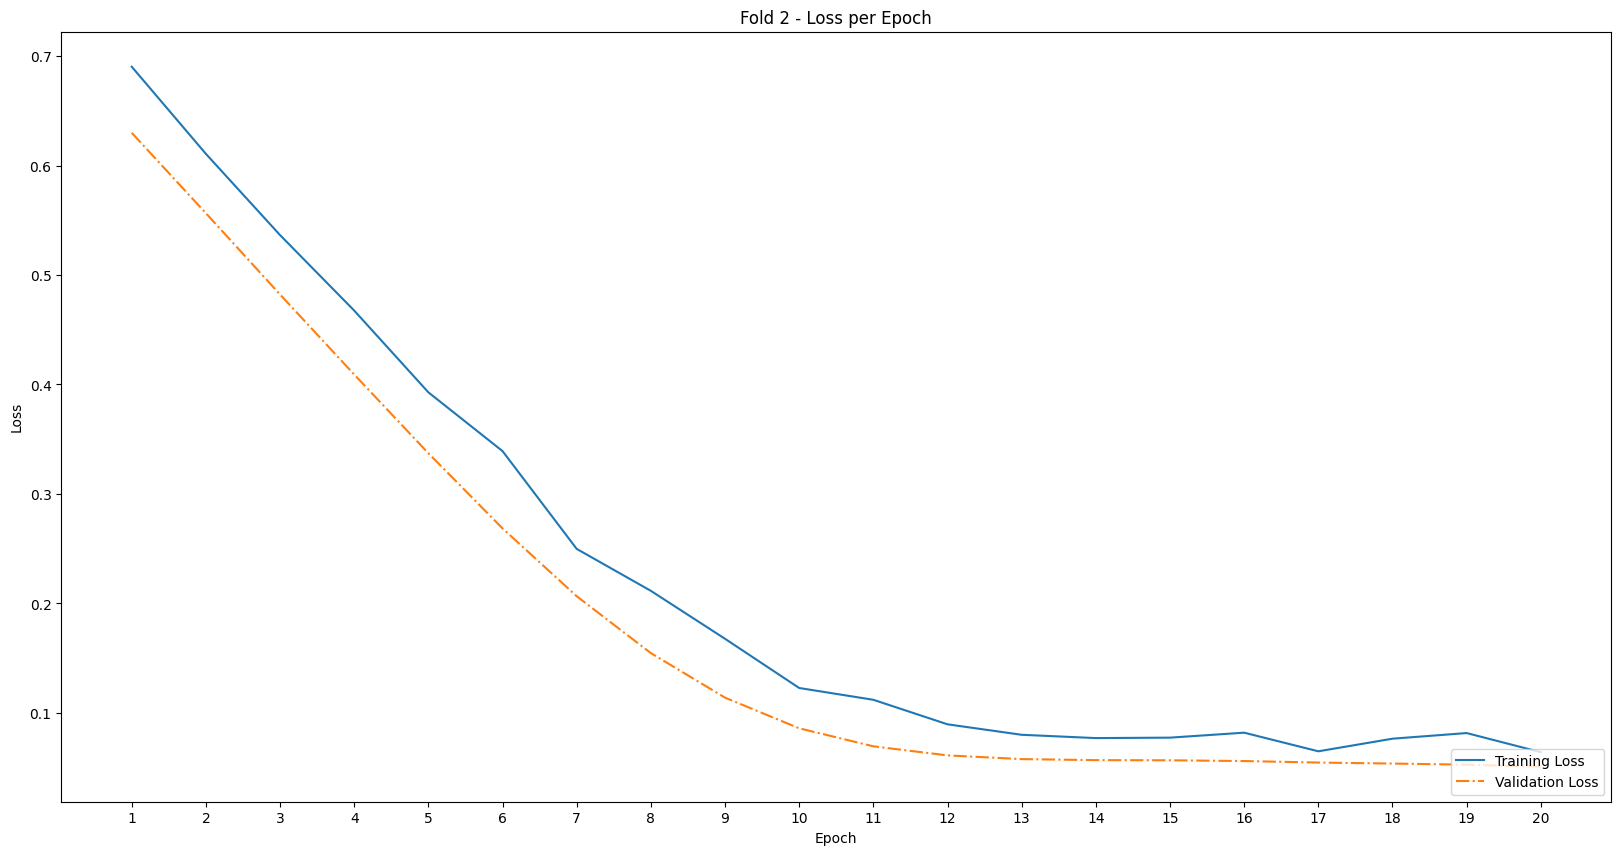

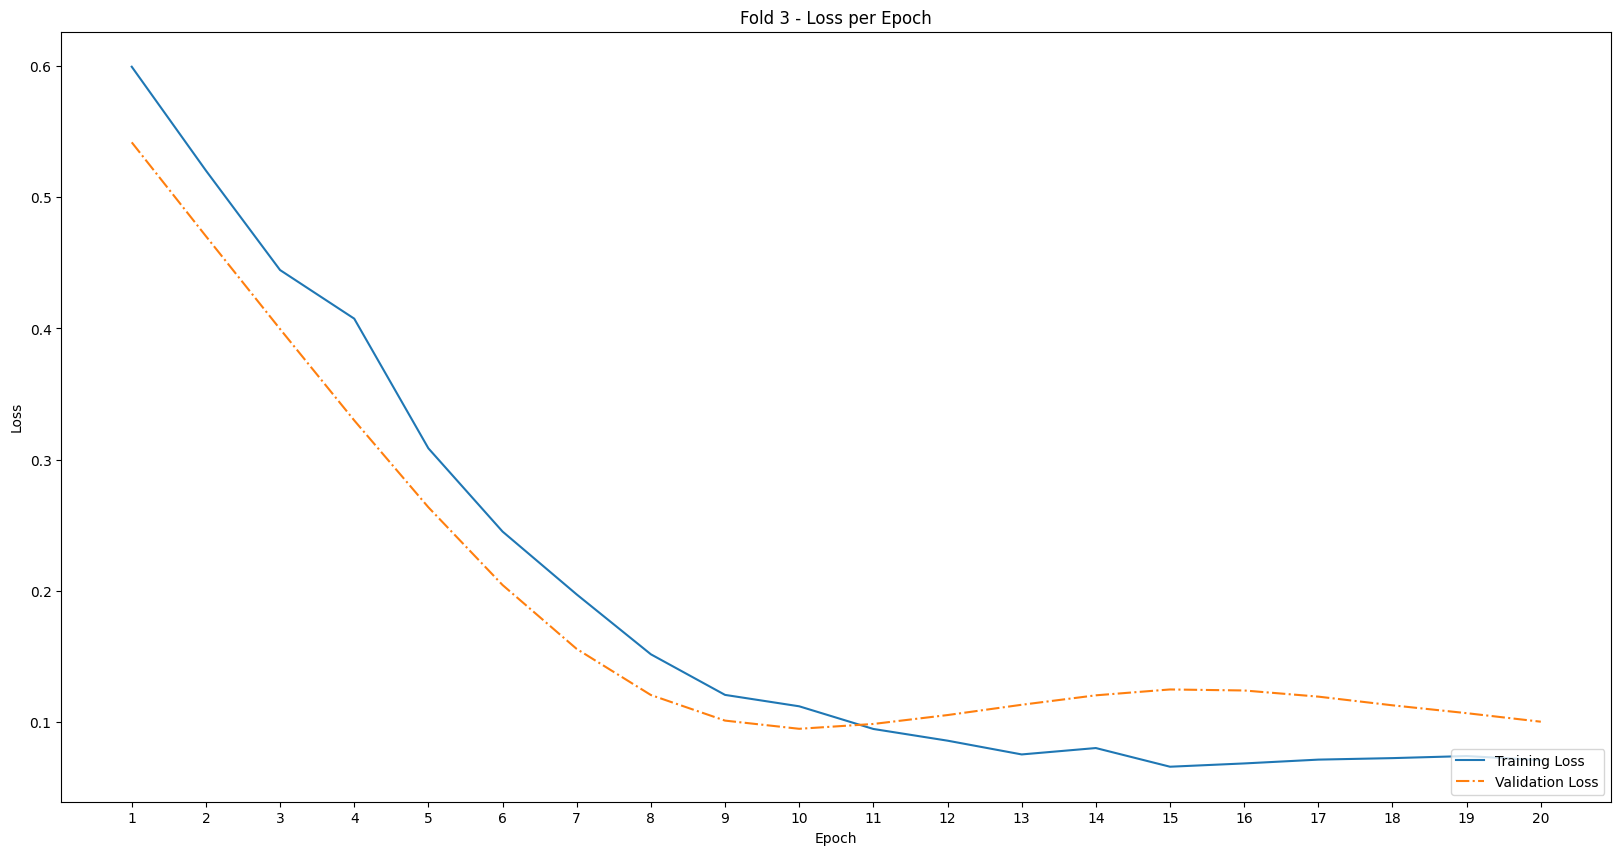

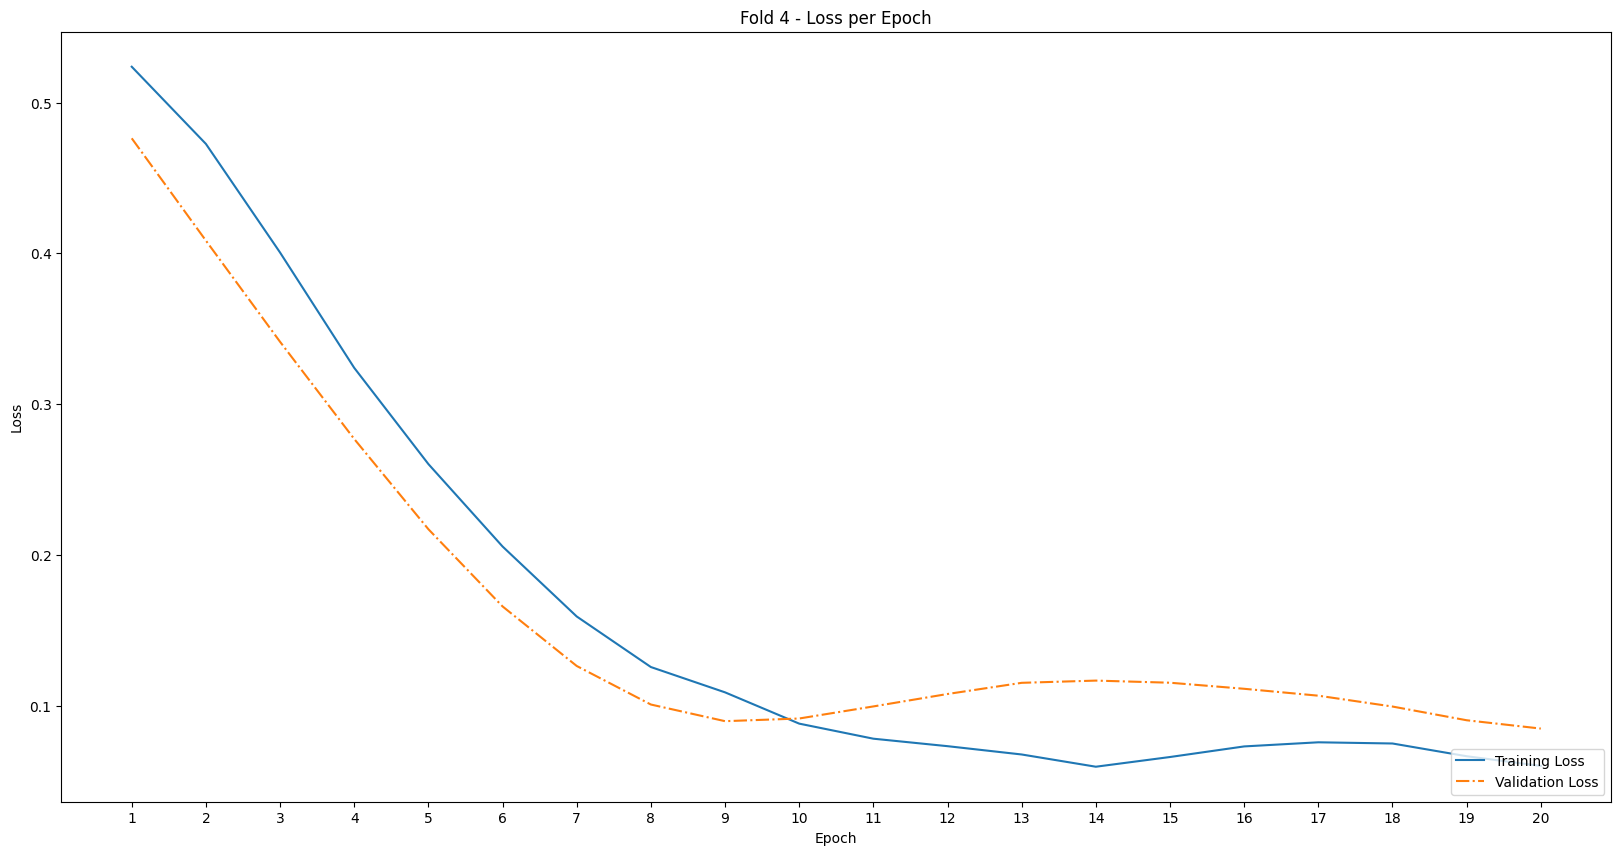

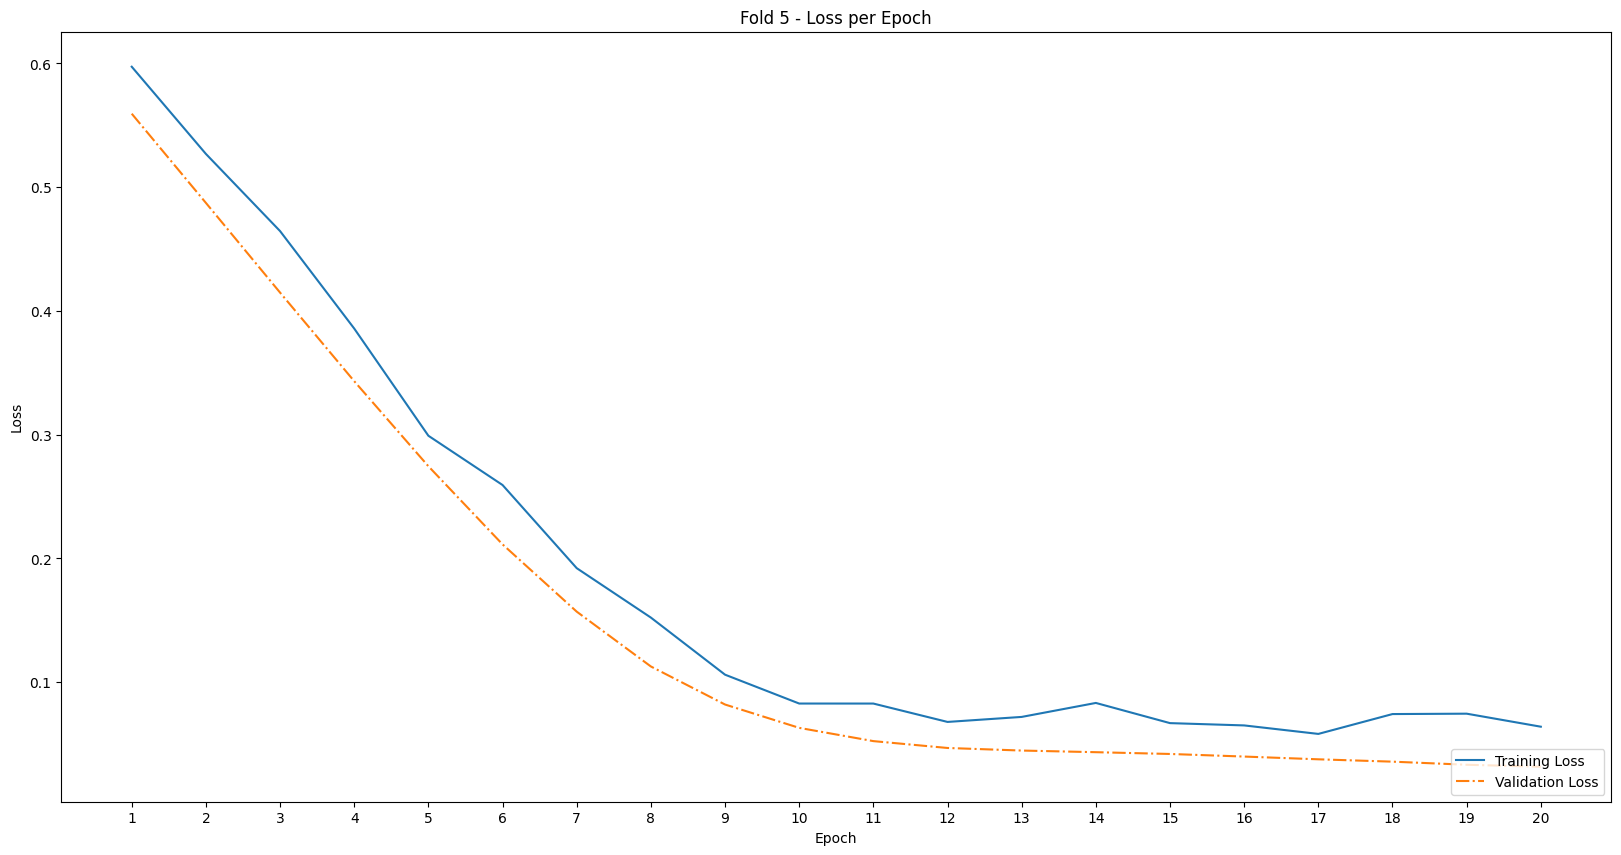

In [33]:
for i in range(5):
  x = np.arange(1, 21)
  y_train_loss = np.asarray(training_losses[i], dtype=np.float32)
  y_val_loss = np.asarray(validation_losses[i], dtype=np.float32)

  plt.figure(figsize=(20,10))

  plt.plot(x, y_train_loss[0:20])
  plt.plot(x, y_val_loss[0:20], '-.')

  plt.xticks(np.arange(min(x), max(x)+1, 1.0))
  plt.legend(["Training Loss", "Validation Loss"], loc="lower right")

  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title(f'Fold {i + 1} - Loss per Epoch')
  plt.show()

### Save Model

In [34]:
# save_path = 'model/class/'
# !mkdir -p model/class/

# model_class_path = os.path.join(save_path, "indobert_class_tesaurus"+".pth")

# model.to('cpu')
# torch.save(model, model_class_path)

## Test

In [35]:
for fold_i in range(5):

  tr_loss = 0

  save_path = 'model_indobert/class_tesaurus_checkpoint/fold_' + str(fold_i)
  model_class_path = os.path.join(save_path, "indobert_class_tesaurus_checkpoint_19.pth")
  model = torch.load(model_class_path)

  model.to(DEVICE)

  model.eval()

  nb_classes = 19

  true_recaps = [[] for i in range(5)]
  false_recaps = [[] for i in range(5)]

  conf_matrix = torch.zeros(nb_classes, nb_classes)
  # Untuk setiap data di training data
  for data in test_instances:

    with torch.no_grad():
      # Mendapatkan output dari model
      input, gold = data
      input = input.to(DEVICE)
      gold = gold.to(DEVICE)
      pred = model(input)

      # Categorical Cross-Entropy --- Loss Function
      loss = loss_func(pred, gold)
      # _, pred = torch.max(pred, 1)
        # for t, p in zip(gold.view(-1), pred.view(-1)):
        #   confusion_matrix[t.long(), p.long()] += 1

      # akumulasi loss dalam 1 epoch
      tr_loss += loss.item()

      conf_matrix = confusion_matrix(gold, pred, conf_matrix)

      for input_recap, gold_recap, pred_recap in zip(input.to('cpu'), gold.to('cpu'), pred.to('cpu')):
        input_recap_sentence = tokenizer.decode(input_recap)
        _, gold_idx = torch.max(gold_recap, 0)
        _, pred_idx = torch.max(pred_recap, 0)
        if gold_idx == pred_idx:
          true_recaps[fold_i].append((input_recap_sentence, gold_idx, pred_idx))
        else:
          false_recaps[fold_i].append((input_recap_sentence, gold_idx, pred_idx))

  amt, acc, prec, rec, f1 = evaluation_metric(conf_matrix)
  data_conf = {
          'Amount of Data': amt,
          'Accuracy': acc,
          'Precision': prec,
          'Recall': rec,
          'F One': f1
      }

  # rata-rata loss dalam 1 epoch
  avg_loss = tr_loss / test_size
  # accuracy = confusion_matrix.diag()/confusion_matrix.sum(1)

  print("")
  print(f"Average loss di testing data: {avg_loss}")

  fig, ax = plt.subplots(figsize=(40, 20))

  display_labels = ['TS', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18']
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix.detach().cpu().numpy(), display_labels=display_labels)
  disp.plot(ax=ax)
  plt.title(f"Confusion Matrix Fold {fold_i + 1} - Epoch 20")

  plt.show()

  disp_df = pd.DataFrame(data=data_conf,
                          index=display_labels, columns=['Amount of Data', 'Accuracy', 'Precision', 'Recall', 'F One'])
  display(disp_df)

RuntimeError: 0D or 1D target tensor expected, multi-target not supported

In [ ]:
save_path = 'model_indobert/class_tesaurus_checkpoint/fold_3'
model_class_path = os.path.join(save_path, "indobert_class_tesaurus_checkpoint_19.pth")
model = torch.load(model_class_path)

# bert_class = model_class

save_path = 'model/class/'
!mkdir -p model/class/
model_class_path = os.path.join(save_path, "indobert_class_tesaurus"+".pth")

model.to('cpu')
torch.save(model, model_class_path)

In [ ]:
df_true_recaps = pd.DataFrame(true_recaps[3], columns=['question', 'true_label', 'pred_label'])

save_path = 'dataset/'
if not os.path.exists(save_path):
  os.makedirs(save_path)
df_true_recaps.to_csv('dataset/indobert_classification_true_recaps.csv', index=False)

In [ ]:
df_false_recaps = pd.DataFrame(false_recaps[3], columns=['question', 'true_label', 'pred_label'])

save_path = 'dataset/'
if not os.path.exists(save_path):
  os.makedirs(save_path)
df_false_recaps.to_csv('dataset/indobert_classification_false_recaps.csv', index=False)

## Archive

### 1st Try, 300~ EPOCH

In [ ]:
import time

# training image classification

LEARNING_RATE = 5e-5
EPOCH = 500

model.to(DEVICE)

# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE)

for epoch_i in range(0, EPOCH):
  start = time.time()
  print(f"Epoch {epoch_i + 1} / {EPOCH}")

  # Freeze all layers
  for param in model.parameters():
      param.requires_grad = False

  # Unfreeze last layer
  for param in model.bert.encoder.layer[11].parameters():
      param.requires_grad = True

  # Reset the total loss for this epoch.
  tr_loss = 0

  # Put the model into training mode.
  model.train()

  # Untuk setiap data di training data
  for data in train_instances:

    # Mendapatkan output dari model
    input, gold = data
    input = input.to(DEVICE)
    gold = gold.to(DEVICE)
    pred = model(input)

    # Categorical Cross-Entropy --- Loss Function
    loss = loss_func(pred, gold)

    # Agar gradient tidak menumpuk; ini diperlukan sebelum
    # menghitung gradient dengan loss.backward()
    optimizer.zero_grad()

    # hitung gradient
    loss.backward()

    # update parameter
    optimizer.step()

    # akumulasi loss dalam 1 epoch
    tr_loss += loss.item()

  # rata-rata loss dalam 1 epoch
  avg_loss = tr_loss / train_size

  print(f"Average loss: {avg_loss}")

  ### Uji coba di Validation Data
  print("Uji coba di Validation Data ...")

  # model eval, agar layer seperti dropout yang menghasilkan
  # sesuai yang random tidak digunakan
  model.eval()

  val_loss = 0
  pred_labels = []
  true_labels = []

  # Untuk setiap batch di validation data
  for data in valid_instances:

    # jangan track gradient! ini sedang evaluasi, bukan training
    with torch.no_grad():

      # Mendapatkan output dari model
      input, gold = data
      input = input.to(DEVICE)
      gold = gold.to(DEVICE)
      pred = model(input)

      # Categorical Cross-Entropy --- Loss Function
      loss = loss_func(pred, gold)

      # akumulasi loss di validation set
      val_loss += loss.item()

    # akumulasi prediksi
    # _, pred_l = torch.max(output, dim = 1) # outnya adalah 2-tuple: (max, max_indices)
    # pred_labels += pred_l.detach().cpu()
    # _, true_l = torch.max(y, dim = 1)
    # true_labels += true_l.detach().cpu()

  # average loss
  avg_val_loss = val_loss / val_size

  # accuracy
  # pred_labels = torch.stack(pred_labels).numpy()
  # true_labels = torch.stack(true_labels).numpy()
  # val_accuracy = np.sum(pred_labels == true_labels) / len(pred_labels)
  print(f"Average loss di validation data: {avg_val_loss}")
  # print(f"Accuracy di validation data: {val_accuracy}")

  print("")

  end = time.time()
  print("Time " + str(end-start))

  if epoch_i % 100 == 0:
    save_path = 'model/class_checkpoint/'
    !mkdir -p model/class_checkpoint/
    model_class_path = os.path.join(save_path, "indobert_class_checkpoint_" + str(epoch_i) +".pth")
    torch.save(model, model_class_path)

### 2nd Try, 500 EPOCH, Tesaurus

In [ ]:
import time

# training image classification

LEARNING_RATE = 5e-5
EPOCH = 500

model.to(DEVICE)

training_losses = []
validation_losses = []

# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE)

for epoch_i in range(0, EPOCH):
  start = time.time()
  print(f"Epoch {epoch_i + 1} / {EPOCH}")

  # Freeze all layers
  for param in model.parameters():
      param.requires_grad = False

  # Unfreeze last layer
  for param in model.bert.encoder.layer[11].parameters():
      param.requires_grad = True

  # Reset the total loss for this epoch.
  tr_loss = 0

  # Put the model into training mode.
  model.train()

  # Untuk setiap data di training data
  for data in train_instances:

    # Mendapatkan output dari model
    input, gold = data
    input = input.to(DEVICE)
    gold = gold.to(DEVICE)
    pred = model(input)

    # Categorical Cross-Entropy --- Loss Function
    loss = loss_func(pred, gold)

    # Agar gradient tidak menumpuk; ini diperlukan sebelum
    # menghitung gradient dengan loss.backward()
    optimizer.zero_grad()

    # hitung gradient
    loss.backward()

    # update parameter
    optimizer.step()

    # akumulasi loss dalam 1 epoch
    tr_loss += loss.item()

  # rata-rata loss dalam 1 epoch
  avg_loss = tr_loss / train_size

  training_losses.append(avg_loss)

  print(f"Average loss: {avg_loss}")

  ### Uji coba di Validation Data
  print("Uji coba di Validation Data ...")

  # model eval, agar layer seperti dropout yang menghasilkan
  # sesuai yang random tidak digunakan
  model.eval()

  val_loss = 0
  pred_labels = []
  true_labels = []

  # Untuk setiap batch di validation data
  for data in valid_instances:

    # jangan track gradient! ini sedang evaluasi, bukan training
    with torch.no_grad():

      # Mendapatkan output dari model
      input, gold = data
      input = input.to(DEVICE)
      gold = gold.to(DEVICE)
      pred = model(input)

      # Categorical Cross-Entropy --- Loss Function
      loss = loss_func(pred, gold)

      # akumulasi loss di validation set
      val_loss += loss.item()

    # akumulasi prediksi
    # _, pred_l = torch.max(output, dim = 1) # outnya adalah 2-tuple: (max, max_indices)
    # pred_labels += pred_l.detach().cpu()
    # _, true_l = torch.max(y, dim = 1)
    # true_labels += true_l.detach().cpu()

  # average loss
  avg_val_loss = val_loss / val_size

  validation_losses.append(avg_val_loss)

  # accuracy
  # pred_labels = torch.stack(pred_labels).numpy()
  # true_labels = torch.stack(true_labels).numpy()
  # val_accuracy = np.sum(pred_labels == true_labels) / len(pred_labels)
  print(f"Average loss di validation data: {avg_val_loss}")
  # print(f"Accuracy di validation data: {val_accuracy}")

  print("")

  end = time.time()
  print("Time " + str(end-start))

  if epoch_i % 100 == 0:
    nb_classes = 18

    conf_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
      for i, (input, gold) in enumerate(valid_instances):
        input = input.to(DEVICE)
        gold = gold.to(DEVICE)
        pred = model(input)
        # _, gold = torch.max(gold, 1)
        # _, pred = torch.max(pred, 1)
        # for t, p in zip(gold.view(-1), pred.view(-1)):
        #   conf_matrix[t.long(), p.long()] += 1

        conf_matrix = confusion_matrix(gold, pred, conf_matrix)

    amt, acc, prec, rec, f1 = evaluation_metric(conf_matrix)

    print(f"Confusion Matrix in validation data:")
    display_labels = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18']
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix.detach().cpu().numpy(), display_labels=display_labels)
    disp.plot()

    for i, template_index in enumerate(display_labels):
      print(f"Evaluation for {template_index}:")
      print(f"Amount of Data: {amt[i]}")
      print(f"Accuracy: {acc[i]}")
      print(f"Precision: {prec[i]}")
      print(f"Recall: {rec[i]}")
      print(f"F One: {f1[i]}")
      print()

    save_path = 'model/class_tesaurus_checkpoint/'
    !mkdir -p model/class_tesaurus_checkpoint/
    model_class_path = os.path.join(save_path, "indobert_class_tesaurus_checkpoint_" + str(epoch_i) +".pth")
    torch.save(model, model_class_path)

In [ ]:
x = np.arange(1, 501)
y_train_loss = np.asarray(training_losses, dtype=np.float32)
y_val_loss = np.asarray(validation_losses, dtype=np.float32)

plt.figure(figsize=(40,20))

plt.plot(x, y_train_loss)
plt.plot(x, y_val_loss, '-.')

plt.legend(["Training Loss", "Validation Loss"], loc="lower right")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Loss per Epoch')
plt.show()

In [ ]:
x = np.arange(1, 51)
y_train_loss = np.asarray(training_losses, dtype=np.float32)
y_val_loss = np.asarray(validation_losses, dtype=np.float32)

plt.figure(figsize=(40,20))

plt.plot(x, y_train_loss[0:50])
plt.plot(x, y_val_loss[0:50], '-.')

plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.legend(["Training Loss", "Validation Loss"], loc="lower right")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Loss per Epoch')
plt.show()

In [ ]:
save_path = 'model/'
model_class_path = os.path.join(save_path, "class_tesaurus_checkpoint/indobert_class_tesaurus_checkpoint_100"+".pth")
# model_class_path = os.path.join(save_path, "class/indobert_class_v1"+".pth")

bert_class = torch.load(model_class_path)

# bert_class = model_class

In [ ]:
  tr_loss = 0

  model.to(DEVICE)

  bert_class.eval()

  nb_classes = 18

  conf_matrix = torch.zeros(nb_classes, nb_classes)
  # Untuk setiap data di training data
  for data in test_instances:

    with torch.no_grad():
      # Mendapatkan output dari model
      input, gold = data
      input = input.to(DEVICE)
      gold = gold.to(DEVICE)
      pred = bert_class(input)

      # Categorical Cross-Entropy --- Loss Function
      loss = loss_func(pred, gold)
      # _, pred = torch.max(pred, 1)
        # for t, p in zip(gold.view(-1), pred.view(-1)):
        #   confusion_matrix[t.long(), p.long()] += 1


      # akumulasi loss dalam 1 epoch
      tr_loss += loss.item()

      conf_matrix = confusion_matrix(gold, pred, conf_matrix)

  amt, acc, prec, rec, f1 = evaluation_metric(conf_matrix)

  # rata-rata loss dalam 1 epoch
  avg_loss = tr_loss / test_size
  # accuracy = confusion_matrix.diag()/confusion_matrix.sum(1)

  print(f"Average loss di testing data: {avg_loss}")
  print(f"Confusion Matrix in testing data: ")

  fig, ax = plt.subplots(figsize=(40, 20))

  display_labels = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18']
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix.detach().cpu().numpy(), display_labels=display_labels)
  disp.plot(ax=ax)

  plt.show()

  for i, template_index in enumerate(display_labels):
      print(f"Evaluation for {template_index}:")
      print(f"Amount of Data: {amt[i]}")
      print(f"Accuracy: {acc[i]}")
      print(f"Precision: {prec[i]}")
      print(f"Recall: {rec[i]}")
      print(f"F One: {f1[i]}")
      print()